# **Instituto Tecnológico de Costa Rica**
## Escuela de computación Ingeniería en computación
## IC6400 - Investigación de operaciones
## Trabajo práctico 2: Investigación de Operaciones
## Ph. D. Saúl Calderón Ramírez

##Integrantes
 * Brandon Retana Chacón
 * Ervin Rodríguez Villanueva
 * Josué David Castro Ramírez

In [1]:
!pip install optuna
!pip install pytest

In [2]:
import torch as torch
from matplotlib import pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from matplotlib import cm
import numpy as np
import pandas as pd
import inspect
import optuna
import os
import plotly.express as px
import pytest

# Functions
---

Se definen acá las tres funciones a optimizar: $f_0$, $f_1$ y $f_2$

- $f_0(x_1,x_2) = x_1^2 + x_2^2$
- $f_1(x_1,x_2) = (1.5 - x_1 +x_1x_2)^2 + (2.25 -x_1 + x_1x_2^2)^2 + (2.625 - x_1 +x_1x_2^3)^2$
- $f_2(x_1,x_2) = 0.26(x_1^2 + x_2^2) - 0.48x_1x_2$

In [3]:
def f0(x):
  """
  The function f0 calculates the sum of the squares of the elements in a given list.

  @param x The parameter `x` is a list containing two elements.

  @return the sum of the squares of the first two elements of the input list `x`.
  """
  return x[0]**2 + x[1]**2

def f1(x):
  """
  The function f1 calculates the sum of squares of three expressions involving the variables x[0] and
  x[1].

  @param x The parameter `x` is a list containing two elements.

  @return The function f1 returns the value of the expression (1.5 - x[0] + x[0]*x[1])**2 + (2.25 -
  x[0] + x[0] * x[1]**2)**2 + (2.625 - x[0] + x[0] * x[1]**3)**2.
  """
  return (1.5 - x[0] + x[0]*x[1])**2 + (2.25 - x[0] + x[0] * x[1]**2)**2 + (2.625 - x[0] + x[0] * x[1]**3)**2

def f2(x):
  """
  The function f2 calculates a specific mathematical expression using two input variables.

  @param x The parameter `x` is a list containing two elements.

  @return The function f2 returns the value of the expression 0.26*(x[0]**2 + x[1]**2) -
  0.48*x[0]*x[1].
  """
  return 0.26*(x[0]**2 + x[1]**2) - 0.48*x[0]*x[1]

# Derivates
---

Se definen acá los vectores gradiente de las tres funciones a optimizar: $f_0$, $f_1$ y $f_2$

- $\nabla \vec{x}f_0 = \begin{bmatrix}2x_1\\ 2x_2 \end{bmatrix}^T$

- $\nabla \vec{x}f_1 = \begin{bmatrix} 2 x_1 x_2^6 + 2 x_1 x_2^4 - 4 x_1 x_2^3 + 5.25  x_2^3 - 2 x_1 x_2^2 + 4.5 x_2^2 - 4 x_1 x_2 + 3 x_2 + 6 x_1 - 12.75 \\ 6 x_1^2 x_2^5 + 4 x_1^2 x_2^3 - 6 x_1^2 x_2^2 + 15.75 x_1 x_2^2 + 9 x_1 x_2 - 2 x_1^2 x_2 - 2 x_1^2 + 3 x_1\end{bmatrix}^T$

- $\nabla \vec{x}f_2 = \begin{bmatrix} 0.52x_1 - 0.48 x_2\\ 0.52x_2 - 0.48 x_1 \end{bmatrix}^T$

In [4]:
def gradient_f0(x):
  """
  The function calculates the gradient of a function f0 with respect to its input x.

  @param x The parameter `x` is a tensor of shape (2,) representing a point in 2-dimensional space.

  @return a torch tensor containing the partial derivatives of the function f0 with respect to x and
  y.
  """
  df_dx = 2*x[0]
  df_dy = 2*x[1]
  return torch.tensor([df_dx, df_dy])

def gradient_f1(x):
  """
  The function `gradient_f1` calculates the gradient of a mathematical function with respect to its
  input variables.

  @param x The parameter `x` is a list or array containing two elements.

  @return a torch tensor containing the partial derivatives of the function f1 with respect to x and
  y.
  """
  df_dx = 2*x[0]*x[1]**6 + 2*x[0]*x[1]**4 - 4*x[0]*x[1]**3 + 5.25*x[1]**3 - 2*x[0]*x[1]**2 + 4.5*x[1]**2 - 4*x[0]*x[1] + 3*x[1] + 6*x[0] - 12.75
  df_dy = 6*x[0]**2*x[1]**5 + 4*x[0]**2*x[1]**3 - 6*x[0]**2*x[1]**2 + 15.75*x[0]*x[1]**2 + 9*x[0]*x[1] - 2*x[0]**2*x[1] - 2*x[0]**2 + 3*x[0]
  return torch.tensor([df_dx, df_dy])

def gradient_f2(x):
  """
  The function `gradient_f2` calculates the gradient of a function with respect to its input
  variables.

  @param x The parameter `x` is a list or array-like object containing two elements.

  @return a torch tensor containing the partial derivatives of the function f2 with respect to x and
  y.
  """
  df_dx = 0.52*x[0] - 0.48*x[1]
  df_dy = 0.52*x[1] - 0.48*x[0]
  return torch.tensor([df_dx, df_dy])

# Hessian Matrix
---

Se definen acá la matriz hessiana inversa para las tres funciones a optimizar: $f_0$, $f_1$ y $f_2$; respectivamente de la siguiente forma:

- $ H(f_i) = \begin{bmatrix} \dfrac{\partial^2 f}{\partial x^2} & \dfrac{\partial^2 f}{\partial x \partial y} \\ \dfrac{\partial^2 f}{\partial y \partial x} & \dfrac{\partial^2 f}{\partial y^2} \end{bmatrix}$



In [5]:
def inverse_hessian_matrix_f0(point):
  """
  The function returns the inverse Hessian matrix of a given point.

  @param point The parameter "point" is a tensor representing a point in the input space.

  @return a torch tensor representing the inverse Hessian matrix of the function f0 at the given
  point. The inverse Hessian matrix is a square matrix that represents the second-order partial
  derivatives of the function with respect to its variables. In this case, the matrix is a 2x2 matrix
  with diagonal elements equal to 1/2 and off-diagonal elements equal to 0.
  """
  return torch.tensor([[1/2,0],
                       [0,1/2]])


def inverse_hessian_matrix_f1(point):
  """
  The function `inverse_hessian_matrix_f1` calculates and returns the inverse Hessian matrix for a
  given point.

  @param point The parameter "point" is a list containing two elements, representing the x and y
  coordinates of a point in a two-dimensional space.

  @return a torch tensor representing the inverse Hessian matrix at the given point.
  """
  numerator_a = (-1.77635683940025e-15 - 7.105427357601e-15*point[1] - 54.0*point[0] - 153.0*point[0]*point[1] + 12.0*point[0]**2 - 2.8421709430404e-14*point[1]**2 + 64.0*point[1]*point[0]**2 + 144.0*point[0]*point[1]**2 - 124.0*point[0]**2*point[1]**2 + 16.0*point[0]**2*point[1]**3 + 99.0*point[0]*point[1]**3 + 108.0*point[0]*point[1]**4 - 200.0*point[0]**2*point[1]**4 + 192.0*point[0]**2*point[1]**5 - 63.0*point[0]*point[1]**5 + 40.0*point[0]**2*point[1]**6 - 18.0*point[0]*point[1]**6 + 144.0*point[0]**2*point[1]**7 - 63.0*point[0]*point[1]**7 - 84.0*point[0]**2*point[1]**8 - 60.0*point[0]**2*point[1]**10)
  denominator_a = (54.0 + 288.0*point[1] - 468.0*point[0] - 1182.0*point[0]*point[1] + 168.0*point[0]**2 + 819.0*point[1]**2 + 464.0*point[1]*point[0]**2 + 396.0*point[0]*point[1]**2 - 512.0*point[0]**2*point[1]**2 + 855.0*point[1]**3 + 32.0*point[0]**2*point[1]**3 + 144.0*point[0]*point[1]**3 - 194.625*point[1]**4 + 1116.0*point[0]*point[1]**4 - 1216.0*point[0]**2*point[1]**4 - 2153.25*point[1]**5 + 2466.0*point[0]*point[1]**5 + 48.00*point[0]**2*point[1]**5 - 1261.125*point[1]**6 + 512.0*point[0]**2*point[1]**6 + 768.0*point[0]*point[1]**6 - 317.25*point[1]**7 + 192.0*point[0]*point[1]**7 + 64.00*point[0]**2*point[1]**7 + 847.125*point[1]**8 + 1328.0*point[0]**2*point[1]**8 - 3204.0*point[0]*point[1]**8 + 567.0*point[1]**9 - 1290.0*point[0]*point[1]**9 - 272.0*point[0]**2*point[1]**9 + 496.125*point[1]**10 + 640.0*point[0]**2*point[1]**10 - 1116.0*point[0]*point[1]**10 + 1152.0*point[0]*point[1]**11 - 1248.0*point[0]**2*point[1]**11 + 64.0*point[0]**2*point[1]**12 + 396.0*point[0]*point[1]**12 + 630.0*point[0]*point[1]**13 - 624.0*point[0]**2*point[1]**13 + 384.0*point[0]**2*point[1]**14 + 168.0*point[0]**2*point[1]**16)
  a = numerator_a/denominator_a

  numerator_b = (18.0 + 42.0*point[1] - 24.0*point[0] - 8.0*point[0]*point[1] + 52.5*point[1]**2 - 48.0*point[0]*point[1]**2 - 93.0*point[1]**3 + 120.0*point[0]*point[1]**3 - 61.5*point[1]**4 - 45.0*point[1]**5 + 96.0*point[0]*point[1]**5 + 37.5*point[1]**6 - 112.0*point[0]*point[1]**6 + 18.0*point[1]**7 - 16.0*point[0]*point[1]**7 + 31.5*point[1]**8 - 72.0*point[0]*point[1]**8 + 40.0*point[0]*point[1]**9 + 24.0*point[0]*point[1]**11)
  denominator_b = (54.0 + 288.0*point[1] - 468.0*point[0] - 1182.0*point[0]*point[1] + 168.0*point[0]**2 + 819.0*point[1]**2 + 464.0*point[1]*point[0]**2 + 396.0*point[0]*point[1]**2 - 512.0*point[0]**2*point[1]**2 + 855.0*point[1]**3 + 32.0*point[0]**2*point[1]**3 + 144.0*point[0]*point[1]**3 - 194.625*point[1]**4 + 1116.0*point[0]*point[1]**4 - 1216.0*point[0]**2*point[1]**4 - 2153.25*point[1]**5 + 2466.0*point[0]*point[1]**5 + 48.00*point[0]**2*point[1]**5 - 1261.125*point[1]**6 + 512.0*point[0]**2*point[1]**6 + 768.0*point[0]*point[1]**6 - 317.25*point[1]**7 + 192.0*point[0]*point[1]**7 + 64.00*point[0]**2*point[1]**7 + 847.125*point[1]**8 + 1328.0*point[0]**2*point[1]**8 - 3204.0*point[0]*point[1]**8 + 567.0*point[1]**9 - 1290.0*point[0]*point[1]**9 - 272.0*point[0]**2*point[1]**9 + 496.125*point[1]**10 + 640.0*point[0]**2*point[1]**10 - 1116.0*point[0]*point[1]**10 + 1152.0*point[0]*point[1]**11 - 1248.0*point[0]**2*point[1]**11 + 64.0*point[0]**2*point[1]**12 + 396.0*point[0]*point[1]**12 + 630.0*point[0]*point[1]**13 - 624.0*point[0]**2*point[1]**13 + 384.0*point[0]**2*point[1]**14 + 168.0*point[0]**2*point[1]**16)
  b = numerator_b/denominator_b

  numerator_c = 3.0 + 9.0*point[1] - 4.0*point[0] - 4.0*point[0]*point[1] + 15.75*point[1]**2 - 12.0*point[0]*point[1]**2 + 8.0*point[0]*point[1]**3 + 12.0*point[0]*point[1]**5
  denominator_c = 9.0 + 54.0*point[1] - 78.0*point[0] - 249.0*point[0]*point[1] + 28.0*point[0]**2 + 175.5*point[1]**2 + 96.0*point[1]*point[0]**2 - 12.0*point[0]**2*point[1]**2 - 126.0*point[0]*point[1]**2 + 283.5*point[1]**3 + 48.0*point[0]**2*point[1]**3 - 195.0*point[0]*point[1]**3 + 248.0625*point[1]**4 - 126.0*point[0]*point[1]**4 - 120.0*point[0]**2*point[1]**4 + 261.0*point[0]*point[1]**5 - 95.99*point[0]**2*point[1]**5 + 8.0*point[0]**2*point[1]**6 + 198.0*point[0]*point[1]**6 + 315.0*point[0]*point[1]**7 - 144.0*point[0]**2*point[1]**7 + 108.0*point[0]**2*point[1]**8 + 84.0*point[0]**2*point[1]**10
  c = numerator_c/denominator_c

  numerator_d = -6.0 + 4.0*point[1] + 2.0*point[1]**2 + 4.0*point[1]**3 - 2.0*point[1]**4 - 2.0*point[1]**6
  denominator_d = 9.0 + 54.0*point[1] - 78.0*point[0] - 249.0*point[0]*point[1] + 28.0*point[0]**2 + 175.5*point[1]**2 + 96.0*point[1]*point[0]**2 - 12.0*point[0]**2*point[1]**2 - 126.0*point[0]*point[1]**2 + 283.5*point[1]**3 + 48.0*point[0]**2*point[1]**3 - 195.0*point[0]*point[1]**3 + 248.0625*point[1]**4 - 126.0*point[0]*point[1]**4 - 120.0*point[0]**2*point[1]**4 + 261.0*point[0]*point[1]**5 - 95.99*point[0]**2*point[1]**5 + 8.0*point[0]**2*point[1]**6 + 198.0*point[0]*point[1]**6 + 315.0*point[0]*point[1]**7 - 144.0*point[0]**2*point[1]**7 + 108.0*point[0]**2*point[1]**8 + 84.0*point[0]**2*point[1]**10
  d = numerator_d/denominator_d

  matrix = [[a,b],
            [c,d]]

  return torch.tensor(matrix)

def inverse_hessian_matrix_f2(point):
  """
  The function returns a torch tensor representing the inverse Hessian matrix for a given point.

  @param point The parameter "point" is a variable that represents a point in a mathematical function.
  It is used as an input to calculate the inverse Hessian matrix for that point.

  @return a torch tensor representing the inverse Hessian matrix of the function f2 at the given
  point.
  """
  return torch.tensor([[13, 12],
                       [12, 13]])

# Algoritms
---

A continuación se definen los cuatro algoritmos a implementar en el proyecto:

- Descenso del Gradiente (Vanilla)
- Newton Raphson
- Descenso del Gradiente Adaptativo. (Adagrad)
- Simulated Annealing

## Figures Plot
---

In [6]:
def plot_learning_curves(loss_history, path, function):
  """
  The function `plot_learning_curves` saves learning curves for a given loss history and function to a
  specified path.

  @param loss_history A list of lists, where each inner list represents the loss values at each
  iteration during the optimization process.
  @param path The `path` parameter is the directory path where the learning curve plots will be saved.
  @param function The `function` parameter is a string that represents the name or description of the
  function being optimized. It is used to generate the title of the learning curve plot.
  """
  if not os.path.exists(path):
    os.makedirs(path)
  for i, history in enumerate(loss_history):
    plt.figure()
    plt.plot(range(len(history)), history)
    plt.xlabel('Iteraciones')
    plt.ylabel('Pérdida')
    plt.title(f'Curva de Aprendizaje de {function} durante la Optimización (Iteración {i})')
    file_name = os.path.join(path, f'curva_aprendizaje_f0_i{i}.svg')
    plt.savefig(file_name, format='svg')

## Vanilla
---

Se implementa la fórmula :
$$\vec{x}(t+1) = \vec{x}(t) - \alpha \nabla_\vec{x}f(\vec{x}(t))$$


In [7]:
loss, hist, pos = 0, 1, 2

def gradient_descent(function, gradient, alpha = 0.1, seed = 40, T = 25):
    """
    The function `gradient_descent` performs gradient descent optimization on a given function using a
    specified learning rate, initial seed, and number of iterations.

    @param function The function parameter is the objective function that you want to minimize using
    gradient descent. It should take a tensor as input and return a scalar value.
    @param gradient The gradient parameter is a function that calculates the gradient of the given
    function at a given point. It takes the current point as input and returns the gradient vector.
    @param alpha The learning rate, which determines the step size taken in each iteration of the
    gradient descent algorithm. It controls how quickly or slowly the algorithm converges to the optimal
    solution. A smaller learning rate may result in slower convergence but more accurate results, while
    a larger learning rate may result in faster convergence but less
    @param seed The seed parameter is used to set the random seed for generating the initial position of
    the optimization algorithm. This ensures that the initial position is the same every time the
    function is called, allowing for reproducibility of results.
    @param T The parameter T represents the number of iterations or steps that the gradient descent
    algorithm will take to find the minimum of the function.

    @return three values: the final loss value, a list of the historical loss values at each iteration,
    and a list of the positions at each iteration.
    """
    f_hist = []
    pos = []
    torch.manual_seed(40)
    x_t = torch.rand(2) * 10

    for i in range(0, T):
        f_x_t = function(x_t)
        f_hist += [f_x_t.item()]
        pos.append([x_t[0].item(), x_t[1].item()])
        delta_x = -1 * gradient(x_t)
        x_t += alpha * delta_x

    loss = function(x_t)
    return loss, f_hist, pos

### Optimización con Optuna
---

Se optimizan las funciones $f_0$, $f_1$ y $f_2$ con la siguiente sugerencia de valores:

- $\alpha$ :
    - $f_0$, $f_2$: valores en el rango $[0, 5]$
    - $f_1$: valores en el rango $[1 \times 10^{-10}, 1 \times 10^{-5}]$


In [8]:
#---------------------------f0--------------------------
loss_history_vanilla_f0 = []
def optimize_vanilla_f0(trial):
    """
    The function `optimize_vanilla_f0` uses a trial object to suggest a value for the parameter `alpha`,
    and then uses gradient descent to optimize the function `f0` with the suggested value of `alpha`.

    @param trial The `trial` parameter is an object that is used to track the progress of the
    optimization algorithm. It is typically provided by the optimization framework you are using, such
    as Optuna or Hyperopt. The `trial` object allows you to suggest new values for hyperparameters and
    track the performance of different

    @return The function `optimize_vanilla_f0` returns the result of the gradient descent optimization
    algorithm, which is the optimized value of the function `f0`.
    """
    a = trial.suggest_float('alpha', 0.0, 5.0)
    calc = gradient_descent(f0, gradient_f0, alpha = a)
    loss_history_vanilla_f0.append(calc[1])
    return calc[0]

#---------------------------f1--------------------------
loss_history_vanilla_f1 = []
def optimize_vanilla_f1(trial):
    """
    The function `optimize_vanilla_f1` uses a trial object to suggest a value for the alpha parameter,
    performs gradient descent using the suggested alpha value, and appends the loss history to a list.

    @param trial The `trial` parameter is an object that is used to track the progress of the
    optimization trial. It is typically provided by an optimization framework such as Optuna. The
    `suggest_float` method of the `trial` object is used to suggest a value for the `alpha` parameter,
    which is

    @return the loss value calculated by the gradient descent algorithm.
    """
    a = trial.suggest_float('alpha', 1e-10, 1e-5)
    calc = gradient_descent(f1, gradient_f1, alpha = a)
    loss_history_vanilla_f1.append(calc[1])
    return calc[loss]

#---------------------------f2--------------------------
loss_history_vanilla_f2 = []
def optimize_vanilla_f2(trial):
    """
    The function `optimize_vanilla_f2` performs gradient descent optimization on a function `f2` using a
    specified learning rate `alpha` and stores the loss history in a list.

    @param trial The `trial` parameter is an object that is used to track the progress of the
    optimization trial. It is typically provided by an optimization framework such as Optuna. The
    `suggest_float` method of the `trial` object is used to suggest a value for the `alpha` parameter,
    which is

    @return the loss value calculated by the gradient descent algorithm.
    """
    a = trial.suggest_float('alpha', 0.0, 5.0)
    calc = gradient_descent(f2, gradient_f2, alpha = a)
    loss_history_vanilla_f2.append(calc[1])
    return calc[loss]

In [9]:
#---------------------------f0--------------------------
# The above code is performing hyperparameter optimization using the Optuna library in Python. It
# creates a study object called `study_vanilla_f0` and then calls the `optimize` method on it, passing
# in the function `optimize_vanilla_f0` as the objective function and setting the number of trials to
# 100.
study_vanilla_f0 = optuna.create_study()
study_vanilla_f0.optimize(optimize_vanilla_f0, n_trials = 100)

best_alpha_vanilla_f0 = study_vanilla_f0.best_params['alpha']
best_loss_f0 = study_vanilla_f0.best_value

#---------------------------f1--------------------------
# The above code is performing hyperparameter optimization using Optuna library in Python. It creates
# a study object called `study_vanilla_f1` with the objective of minimizing the value. It then calls
# the `optimize` method on the study object, passing the `optimize_vanilla_f1` function as the
# objective function to be optimized. The `n_trials` parameter specifies the number of trials to be
# performed during the optimization process.
study_vanilla_f1 = optuna.create_study(direction='minimize')
study_vanilla_f1.optimize(optimize_vanilla_f1, n_trials = 100)

best_alpha_vanilla_f1 = study_vanilla_f1.best_params['alpha']
best_loss_f1 = study_vanilla_f1.best_value

#---------------------------f2--------------------------
# The above code is using the Optuna library in Python to perform hyperparameter optimization for a
# function called `optimize_vanilla_f2`. It creates an Optuna study object called `study_vanilla_f2`
# and then calls the `optimize` method on it, specifying `n_trials = 50` to run 50 trials of the
# optimization process.
study_vanilla_f2 = optuna.create_study()
study_vanilla_f2.optimize(optimize_vanilla_f2, n_trials = 50)

best_alpha_vanilla_f2 = study_vanilla_f2.best_params['alpha']
best_loss_f2 = study_vanilla_f2.best_value

[I 2023-11-06 18:44:32,062] A new study created in memory with name: no-name-c6a14f68-d4f0-4988-aeea-60f9b298502f
[I 2023-11-06 18:44:32,077] Trial 0 finished with value: 77176.0 and parameters: {'alpha': 1.072500962451518}. Best is trial 0 with value: 77176.0.
[I 2023-11-06 18:44:32,093] Trial 1 finished with value: 1.2121794209566461e-18 and parameters: {'alpha': 0.2996921818963749}. Best is trial 1 with value: 1.2121794209566461e-18.
[I 2023-11-06 18:44:32,106] Trial 2 finished with value: inf and parameters: {'alpha': 3.24399390817165}. Best is trial 1 with value: 1.2121794209566461e-18.
[I 2023-11-06 18:44:32,120] Trial 3 finished with value: inf and parameters: {'alpha': 3.5065077353059975}. Best is trial 1 with value: 1.2121794209566461e-18.
[I 2023-11-06 18:44:32,134] Trial 4 finished with value: inf and parameters: {'alpha': 4.400568122692773}. Best is trial 1 with value: 1.2121794209566461e-18.
[I 2023-11-06 18:44:32,147] Trial 5 finished with value: 5.416394335176444e+33 and

### Vanilla Summary
---

In [10]:
# The above code is printing the best alpha value, corresponding loss, and best trial for three
# different functions (f0, f1, f2) from three different studies (study_vanilla_f0, study_vanilla_f1,
# study_vanilla_f2).
best_trial_vanilla_f0 = study_vanilla_f0.best_trial
best_trial_vanilla_f1 = study_vanilla_f1.best_trial
best_trial_vanilla_f2 = study_vanilla_f2.best_trial
#---------------------------f0--------------------------
print("Mejor alpha para f0:", best_alpha_vanilla_f0)
print("Pérdida correspondiente para f0:", best_loss_f0)
print("Mejor intento:", best_trial_vanilla_f0)
print("\n")
#---------------------------f1--------------------------
print("Mejor alpha para f1:", best_alpha_vanilla_f1)
print("Pérdida correspondiente para f1:", best_loss_f1)
print("Mejor intento:", best_trial_vanilla_f1)
print("\n")
#---------------------------f2--------------------------
print("Mejor alpha para f2:", best_alpha_vanilla_f2)
print("Pérdida correspondiente para f2:", best_loss_f2)
print("Mejor intento:", best_trial_vanilla_f2)
print("\n")


Mejor alpha para f0: 0.4544271175981578
Pérdida correspondiente para f0: 0.0
Mejor intento: FrozenTrial(number=31, state=TrialState.COMPLETE, values=[0.0], datetime_start=datetime.datetime(2023, 11, 6, 18, 44, 32, 730966), datetime_complete=datetime.datetime(2023, 11, 6, 18, 44, 32, 761532), params={'alpha': 0.4544271175981578}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'alpha': FloatDistribution(high=5.0, log=False, low=0.0, step=None)}, trial_id=31, value=None)


Mejor alpha para f1: 1.9806691884042193e-06
Pérdida correspondiente para f1: 31.90766143798828
Mejor intento: FrozenTrial(number=11, state=TrialState.COMPLETE, values=[31.90766143798828], datetime_start=datetime.datetime(2023, 11, 6, 18, 44, 34, 413548), datetime_complete=datetime.datetime(2023, 11, 6, 18, 44, 34, 436971), params={'alpha': 1.9806691884042193e-06}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'alpha': FloatDistribution(high=1e-05, log=False, low=1e-10, st

### Graph of optimization history Vanilla
---

In [11]:
path_f0 = '/content/vanilla/f0'
path_f1 = '/content/vanilla/f1'
path_f2 = '/content/vanilla/f2'

#plot_learning_curves(loss_history_f0, path_f0, 'f0')
#plot_learning_curves(loss_history_f1, path_f1, 'f1')
#plot_learning_curves(loss_history_f2, path_f2, 'f2')

## Newton Raphson
---

Se implementa la fórmula :

$$\vec{x}(t+1) = \vec{x}(t) + \Delta\vec{x} ⇒ \vec{x}(t+1) = \vec{x}(t) - \vec{x}(t) = \begin{bmatrix} 0 \\ 0 \end{bmatrix}$$

In [12]:
def newton_rhapson(function, gradient, inverse_hessian, alpha = 1, seed = 40, T = 25):
    """
    The function `newton_rhapson` implements the Newton-Raphson optimization algorithm to find the
    minimum of a given function.

    @param function The function that you want to minimize using the Newton-Raphson method. It takes a
    tensor x_t as input and returns a scalar value representing the loss.
    @param gradient The gradient is a function that calculates the gradient of the objective function at
    a given point. It takes a tensor as input and returns a tensor of the same shape as the input.
    @param inverse_hessian The inverse_hessian parameter is a function that calculates the inverse of
    the Hessian matrix of the function at a given point. The Hessian matrix is a square matrix of
    second-order partial derivatives of the function with respect to its variables. The inverse_hessian
    function takes a tensor x_t as input and
    @param alpha The alpha parameter is the step size or learning rate used in the Newton-Raphson
    algorithm. It determines how big of a step is taken in each iteration towards the minimum of the
    function. A smaller alpha value will result in smaller steps and slower convergence, while a larger
    alpha value may result in larger
    @param seed The seed parameter is used to set the random seed for reproducibility. It is an optional
    parameter and its default value is 40.
    @param T The parameter T represents the number of iterations or steps that the Newton-Raphson
    algorithm will take to converge to a solution.

    @return three values:
    1. loss: The final value of the objective function at the optimized point.
    2. f_hist: A list containing the values of the objective function at each iteration.
    3. pos: A list containing the positions (x, y) at each iteration.
    """
    f_hist = []
    pos = []
    torch.manual_seed(seed)
    x_t = torch.rand(2) * 10

    for i in range(0, T):
        gradient_x = gradient(x_t)
        f_x_t = function(x_t)
        f_hist += [f_x_t.item()]
        pos.append([x_t[0].item(), x_t[1].item()])
        #print("Iteration ", i,  " x_t ", x_t, " f(x_t): ", f_x_t)
        hessian_inverse_x = inverse_hessian(x_t)
        x_t = x_t - alpha * torch.matmul(hessian_inverse_x.float(), gradient_x)
    loss = function(x_t)
    return loss, f_hist, pos

### Optimización con Optuna
---

Se optimizan las funciones $f_0$, $f_1$ y $f_2$ con la siguiente sugerencia de valores:

- $\alpha$ :
    - $f_0$, $f_1$, $f_2$ : valores en el rango $[0.01, 3]$

In [13]:
def optimize_newton_f0(trial):
    """
    The function `optimize_newton_f0` uses the Newton-Raphson method to optimize a function `f0` with
    its gradient and inverse Hessian matrix, using a suggested value for the parameter `alpha`.

    @param trial The `trial` parameter is an object that is used to track the progress of the
    optimization algorithm. It is typically provided by the optimization framework you are using (e.g.,
    Optuna). The `trial` object allows you to suggest new values for hyperparameters and track the
    performance of different trials.

    @return The function `optimize_newton_f0` returns the value of the loss calculated by the
    `newton_rhapson` function.
    """
    alpha = trial.suggest_float('alpha', 0.01, 3.0)
    calc = newton_rhapson(f0, gradient_f0, inverse_hessian_matrix_f0, alpha=alpha)
    return calc[loss]

def optimize_newton_f1(trial):
    """
    The function `optimize_newton_f1` uses the Newton-Raphson optimization algorithm to find the optimal
    value of the parameter `alpha` for a given function `f1`.

    @param trial The `trial` parameter is an object that is used to track the progress of the
    optimization algorithm. It is typically provided by the optimization framework you are using (e.g.,
    Optuna). The `trial` object allows you to suggest new values for the hyperparameters and provides
    methods to track the performance

    @return The function `optimize_newton_f1` returns the loss value calculated by the `newton_rhapson`
    function.
    """
    alpha = trial.suggest_float('alpha', 0.01, 3.0)
    calc = newton_rhapson(f1, gradient_f1, inverse_hessian_matrix_f1, alpha=alpha)
    return calc[loss]

def optimize_newton_f2(trial):
    """
    The function `optimize_newton_f2` uses the Optuna library to optimize the `newton_rhapson` function
    with the `f2` function, its gradient, and inverse Hessian matrix, using the suggested value for the
    `alpha` parameter.

    @param trial The `trial` parameter is an object that is used to track the progress of the
    optimization algorithm. It is typically provided by the optimization framework you are using (e.g.,
    Optuna).

    @return The function `optimize_newton_f2` returns the value of the loss calculated by the
    `newton_rhapson` function.
    """
    alpha = trial.suggest_float('alpha', 0.01, 3.0)
    calc = newton_rhapson(f2, gradient_f2, inverse_hessian_matrix_f2, alpha=alpha)
    return calc[loss]

In [14]:
# The above code is performing hyperparameter optimization using Optuna for three different functions
# (f0, f1, f2) using the Newton optimization algorithm.
loss = 0
f_history = 1
study_newton_f0 = optuna.create_study()
study_newton_f0.optimize(optimize_newton_f0, n_trials = 100)

best_alpha_newton_f0 = study_newton_f0.best_params['alpha']
best_loss_f0 = study_newton_f0.best_value

#---------------------------f1--------------------------
study_newton_f1 = optuna.create_study(direction='minimize')
study_newton_f1.optimize(optimize_newton_f1, n_trials = 100)

best_alpha_newton_f1 = study_newton_f1.best_params['alpha']
best_loss_f1 = study_newton_f1.best_value

#---------------------------f2--------------------------
study_newton_f2 = optuna.create_study()
study_newton_f2.optimize(optimize_newton_f2, n_trials = 50)

best_alpha_newton_f2 = study_newton_f2.best_params['alpha']
best_loss_f2 = study_newton_f2.best_value

[I 2023-11-06 18:44:41,382] A new study created in memory with name: no-name-f1ee5134-8f3f-4b97-8a55-65bd86225682
[I 2023-11-06 18:44:41,395] Trial 0 finished with value: 6.037917423317811e+16 and parameters: {'alpha': 2.9800414694894473}. Best is trial 0 with value: 6.037917423317811e+16.
[I 2023-11-06 18:44:41,417] Trial 1 finished with value: 0.2238779515028 and parameters: {'alpha': 1.8872720588697276}. Best is trial 1 with value: 0.2238779515028.
[I 2023-11-06 18:44:41,436] Trial 2 finished with value: 1.4128832027354687e-22 and parameters: {'alpha': 1.3342402431716842}. Best is trial 2 with value: 1.4128832027354687e-22.
[I 2023-11-06 18:44:41,450] Trial 3 finished with value: 0.018513215705752373 and parameters: {'alpha': 0.1558761110986836}. Best is trial 2 with value: 1.4128832027354687e-22.
[I 2023-11-06 18:44:41,469] Trial 4 finished with value: 4.52937781885202e-15 and parameters: {'alpha': 0.5277441968603134}. Best is trial 2 with value: 1.4128832027354687e-22.
[I 2023-11-

### Newton Rhapson Summary
---

In [15]:
# The above code is printing the best alpha values and corresponding losses for three different
# functions f0, f1, and f2.
#---------------------------f0--------------------------
print("Mejor alpha para f0:", best_alpha_newton_f0)
print("Pérdida correspondiente para f0:", best_loss_f0)
print("\n")
#---------------------------f1--------------------------
print("Mejor alpha para f1:", best_alpha_newton_f1)
print("Pérdida correspondiente para f1:", best_loss_f1)
print("\n")
#---------------------------f2--------------------------
print("Mejor alpha para f2:", best_alpha_newton_f2)
print("Pérdida correspondiente para f2:", best_loss_f2)

Mejor alpha para f0: 0.8866192456589396
Pérdida correspondiente para f0: 0.0


Mejor alpha para f1: 2.03640431633552
Pérdida correspondiente para f1: 1.923374056816101


Mejor alpha para f2: 0.9588324221763161
Pérdida correspondiente para f2: 0.0


###Graph of optimization history of Newton Rhapson
---

In [16]:
path_newton_f0 = '/content/newton/f0'
path_newton_f1 = '/content/newton/f1'
path_newton_f2 = '/content/newton/f2'

# plot_learning_curves(loss_history_newton_f0, path_newton_f0, 'f0')
# plot_learning_curves(loss_history_newton_f1, path_newton_f1, 'f1')
# plot_learning_curves(loss_history_newton_f2, path_newton_f2, 'f2')

## Adaptative Gradient Descent
---
Se implementa la fórmula :

$$ s_i(t) = \gamma s_i (t-1) + (1- \gamma) \sum_{k=1}^{t}\left(\frac{df(\vec{x}(k))}{dx_i}\right)^2$$



In [17]:
def calculate_alpha_i(rho, s_i, epsilon):
  """
  The function calculates the alpha_i value using the given formula.

  @param rho A scalar value representing the global scaling factor.
  @param s_i The parameter `s_i` represents the variance of the input feature `i`.
  @param epsilon Epsilon is a small positive constant added to the denominator to avoid division by
  zero. It is used to ensure numerical stability in the calculation.

  @return the value of rho divided by the square root of s_i plus epsilon.
  """
  return rho/torch.sqrt(s_i + epsilon)


def adaptive_gradient_descent(function, gradient, rho = 0.001, epsilon = 0.0001, seed = 40, T = 25):
  """
  The function `adaptive_gradient_descent` performs adaptive gradient descent optimization on a given
  function using the specified parameters.

  @param function The function that we want to minimize. It takes a tensor of size 2 as input and
  returns a scalar value.
  @param gradient The gradient parameter is a function that calculates the gradient of the function at
  a given point. It takes a tensor x_t as input and returns the gradient as a tensor.
  @param rho The learning rate parameter, which controls the step size in each iteration of the
  gradient descent algorithm. It determines how quickly or slowly the algorithm converges to the
  optimal solution.
  @param epsilon The epsilon parameter is value to avoid undefined zero division
  @param seed The seed parameter is used to set the random seed for reproducibility. It ensures that
  the random numbers generated during the execution of the code are the same every time the code is
  run with the same seed value.
  @param T The parameter T represents the number of iterations or steps that the adaptive gradient
  descent algorithm will take to optimize the function.

  @return three values:
  1. loss: the final value of the function after T iterations.
  2. f_hist: a list containing the values of the function at each iteration.
  3. pos: a list of positions visited during the iterations, where each position is represented as a
  list [x, y].
  """
  alpha_vector = torch.zeros(2)
  sum_of_derivatives = torch.zeros(2)

  f_hist = []
  pos = []
  torch.manual_seed(seed)
  x_t = torch.rand(2) * 10

  for i in range(0, T):
    alpha_vector = calculate_alpha_i(rho, sum_of_derivatives, epsilon)
    calculated_gradient = gradient(x_t)
    f_x_t = function(x_t)
    f_hist += [f_x_t.item()]
    pos.append([x_t[0].item(), x_t[1].item()])
    sum_of_derivatives += calculated_gradient**2
    x_t = x_t - alpha_vector * calculated_gradient

  loss = function(x_t)
  return loss, f_hist, pos

### Optimización con Optuna
---

Se optimizan las funciones $f_0$, $f_1$ y $f_2$ con la siguiente sugerencia de valores:

- $ρ$ :
    - $f_0$, $f_2$ : valores en el rango $[0.001, 1]$
    - $f_1$ : valores en el rango $[1 \times 10^{-10}, 1 \times 10^{-5}]$.

In [18]:
def optimize_adagrad_f0(trial):
    """
    The function `optimize_adagrad_f0` uses Optuna to optimize the parameters `rho` and `epsilon` for
    the adaptive gradient descent algorithm.

    @param trial The `trial` parameter is an object that is used to track the progress of the
    optimization trial. It is provided by the Optuna library and contains methods and attributes that
    can be used to define and manage the search space for the hyperparameters, as well as to store and
    retrieve the results of each

    @return The function `optimize_adagrad_f0` returns the value of the loss calculated by the
    `adaptive_gradient_descent` function.
    """
    rho = trial.suggest_float('rho', 0.001, 1.0)
    epsilon = trial.suggest_float('epsilon', 0.00001, 0.1) # El epsilon no se deberia cambiar, esto es solo un demo para probar optuna :)
    calc = adaptive_gradient_descent(f0, gradient_f0, rho, epsilon)
    return calc[loss]

def optimize_adagrad_f1(trial):
    """
    The function `optimize_adagrad_f1` uses the adaptive gradient descent algorithm to optimize a
    function `f1` with its gradient `gradient_f1` and returns the loss value.

    @param trial The `trial` parameter is an object that is used to track the progress of the
    optimization trial. It is typically provided by an optimization framework such as Optuna or
    Hyperopt. The `trial` object allows you to suggest new values for hyperparameters and track the
    performance of different configurations.

    @return the value of the loss calculated by the adaptive_gradient_descent function.
    """
    rho = trial.suggest_float('rho', 1e-10, 1e-5)
    calc = adaptive_gradient_descent(f1, gradient_f1, rho)
    return calc[loss]

def optimize_adagrad_f2(trial):
    """
    The function `optimize_adagrad_f2` uses the adaptive gradient descent algorithm with the suggested
    value of `rho` to optimize the function `f2` and returns the calculated loss.

    @param trial The `trial` parameter is an object that is used to track the progress of the
    optimization trial. It is typically provided by an optimization framework such as Optuna. The
    `trial` object allows you to suggest values for hyperparameters and track the performance of
    different configurations.

    @return the value of the loss calculated by the adaptive_gradient_descent function.
    """
    rho = trial.suggest_float('rho', 0.001, 1.0)
    calc = adaptive_gradient_descent(f2, gradient_f2, rho)
    return calc[loss]

In [19]:
# The above code is performing hyperparameter optimization using the Optuna library for three
# different functions: f0, f1, and f2. It creates an Optuna study for each function and then uses the
# `optimize` method to search for the best hyperparameters. The `n_trials` parameter specifies the
# number of trials to run for each study. After optimization, the code retrieves the best
# hyperparameters (`best_alpha_ada_f0`, `best_alpha_ada_f1`, `best_alpha_ada_f2`) and the
# corresponding best loss values (`best_loss_ada_f0`, `best
#---------------------------f0--------------------------
study_adagrad_f0 = optuna.create_study()
study_adagrad_f0.optimize(optimize_adagrad_f0, n_trials = 100)

best_alpha_ada_f0 = study_adagrad_f0.best_params['rho']
best_loss_ada_f0 = study_adagrad_f0.best_value

#---------------------------f1--------------------------
study_adagrad_f1 = optuna.create_study(direction='minimize')
study_adagrad_f1.optimize(optimize_adagrad_f1, n_trials = 100)

best_alpha_ada_f1 = study_adagrad_f1.best_params['rho']
best_loss_ada_f1 = study_adagrad_f1.best_value

#---------------------------f2--------------------------
study_adagrad_f2 = optuna.create_study()
study_adagrad_f2.optimize(optimize_adagrad_f2, n_trials = 100)

best_alpha_ada_f2 = study_adagrad_f2.best_params['rho']
best_loss_ada_f2 = study_adagrad_f2.best_value

[I 2023-11-06 18:45:09,228] A new study created in memory with name: no-name-dac45ff7-8d38-4784-a1af-ab6675698de2
[I 2023-11-06 18:45:09,245] Trial 0 finished with value: 489.1428527832031 and parameters: {'rho': 0.5228646597306293, 'epsilon': 0.06502619276772063}. Best is trial 0 with value: 489.1428527832031.
[I 2023-11-06 18:45:09,258] Trial 1 finished with value: 664.7656860351562 and parameters: {'rho': 0.6527503601675987, 'epsilon': 0.07632984989735964}. Best is trial 0 with value: 489.1428527832031.
[I 2023-11-06 18:45:09,268] Trial 2 finished with value: 8.865912437438965 and parameters: {'rho': 0.189383077556791, 'epsilon': 0.06710313217360885}. Best is trial 2 with value: 8.865912437438965.
[I 2023-11-06 18:45:09,282] Trial 3 finished with value: 29.007726669311523 and parameters: {'rho': 0.018791453159987134, 'epsilon': 0.008441395077135271}. Best is trial 2 with value: 8.865912437438965.
[I 2023-11-06 18:45:09,296] Trial 4 finished with value: 52.4775276184082 and parameter

### Adaptative Gradient Descent Summary
---

In [20]:
# The above code is printing the best alpha, corresponding loss, and best trial for three different
# functions (f0, f1, f2) using the Adagrad optimization algorithm.

best_trial_adagrad_f0 = study_adagrad_f0.best_trial
best_trial_adagrad_f1 = study_adagrad_f1.best_trial
best_trial_adagrad_f2 = study_adagrad_f2.best_trial
#---------------------------f0--------------------------
print("Mejor alpha para f0:", best_alpha_ada_f0)
print("Pérdida correspondiente para f0:", best_loss_ada_f0)
print("Mejor intento:", best_trial_adagrad_f0)
print("\n")
#---------------------------f1--------------------------
print("Mejor alpha para f1:", best_alpha_ada_f1)
print("Pérdida correspondiente para f1:", best_loss_ada_f1)
print("Mejor intento:", best_trial_adagrad_f1)
print("\n")
#---------------------------f2--------------------------
print("Mejor alpha para f2:", best_alpha_ada_f2)
print("Pérdida correspondiente para f2:", best_loss_ada_f2)
print("Mejor intento:", best_trial_adagrad_f2)

Mejor alpha para f0: 0.09045787755898171
Pérdida correspondiente para f0: 1.1457574146334082e-05
Mejor intento: FrozenTrial(number=21, state=TrialState.COMPLETE, values=[1.1457574146334082e-05], datetime_start=datetime.datetime(2023, 11, 6, 18, 45, 9, 694975), datetime_complete=datetime.datetime(2023, 11, 6, 18, 45, 9, 720217), params={'rho': 0.09045787755898171, 'epsilon': 0.03276205564147262}, user_attrs={}, system_attrs={}, intermediate_values={}, distributions={'rho': FloatDistribution(high=1.0, log=False, low=0.001, step=None), 'epsilon': FloatDistribution(high=0.1, log=False, low=1e-05, step=None)}, trial_id=21, value=None)


Mejor alpha para f1: 4.6838913739437054e-08
Pérdida correspondiente para f1: 125530848.0
Mejor intento: FrozenTrial(number=83, state=TrialState.COMPLETE, values=[125530848.0], datetime_start=datetime.datetime(2023, 11, 6, 18, 45, 14, 389731), datetime_complete=datetime.datetime(2023, 11, 6, 18, 45, 14, 410607), params={'rho': 4.6838913739437054e-08}, user_at

In [21]:
path_adagrad_f0 = '/content/adagrad/f0'
path_adagrad_f1 = '/content/adagrad/f1'
path_adagrad_f2 = '/content/adagrad/f2'

# plot_learning_curves(adagrad_loss_history_f0, path_f0, 'f0')
# plot_learning_curves(adagrad_loss_history_f1, path_f1, 'f1')
# plot_learning_curves(adagrad_loss_history_f2, path_f2, 'f2')

## Simulated Annelaing
---

Se implementan las fórmulas :

- $\Delta E = E(\vec{x}(t)) - E(\vec{x}(t) + \Delta \vec{x}(t))$

- $T(t) = α T(t-1)$

- $\vec{x}(t+1) = \vec{x}(t) + \Delta\vec{x}(t)$

In [22]:
def probability(delta_E, T_t):
    """
    The function calculates the probability of a certain event occurring based on the change in energy
    (delta_E) and the temperature (T_t).

    @param delta_E The change in energy of a system. It can be positive or negative.
    @param T_t T_t is the temperature of the system.

    @return either 1 or the value of 2.71828 raised to the power of delta_E divided by T_t, depending on
    the value of delta_E.
    """
    if(delta_E > 0):
        return 1
    return 2.71828**(delta_E/T_t)

def simulated_annealing(function, alpha_S, T_t, h, seed=40, T=25):
    """
    The function `simulated_annealing` implements the simulated annealing algorithm to optimize a given
    function.

    @param function The function that you want to optimize using simulated annealing. It should take a
    torch.Tensor as input and return a scalar value.
    @param alpha_S alpha_S is the cooling rate for the simulated annealing algorithm. It determines how
    quickly the temperature decreases over time. A higher value of alpha_S will result in a faster
    cooling rate, while a lower value will result in a slower cooling rate.
    @param T_t T_t is the initial temperature for the simulated annealing algorithm. It determines the
    initial probability of accepting a worse solution. As the algorithm progresses, T_t is decreased
    according to the cooling schedule defined by alpha_S.
    @param h The parameter "h" represents the step size or the size of the neighborhood around the
    current solution. It is used to generate random points within the neighborhood for exploration
    during the simulated annealing process.
    @param seed The seed parameter is used to set the random seed for reproducibility. By setting a
    specific seed value, you can ensure that the random numbers generated during the execution of the
    function will be the same every time you run the function with the same seed value. This can be
    useful for debugging or comparing
    @param T The parameter T represents the number of iterations or steps in the simulated annealing
    algorithm. It determines how many times the algorithm will update the current solution.

    @return three values:
    1. `loss`: The final value of the objective function at the optimized position.
    2. `f_hist`: A list containing the history of objective function values at each iteration.
    3. `pos`: A list containing the positions (x, y coordinates) at each iteration.
    """
    f_hist = []
    pos = []
    torch.manual_seed(seed)
    x_t = torch.rand(2) * 10
    neighborhood = x_t - h, x_t + h

    for i in range(0, T):
        #print("Iteration: ", i, "x(t):",x_t, "f(x_t):", function(x_t))
        E_x_t = function(x_t)
        x_t_2 = torch.rand(2) * (neighborhood[1] - neighborhood[0]) + neighborhood[0]
        delta_E = E_x_t - function(x_t_2)

        if(torch.rand(1) < probability(delta_E, T_t)):
            x_t = x_t_2
            neighborhood = x_t - h, x_t + h
        T_t = alpha_S * T_t
        f_hist += [E_x_t.item()]
        pos.append([x_t[0].item(), x_t[1].item()])

    loss = function(x_t)
    return loss, f_hist, pos

### Optimización con Optuna
---

Se optimizan las funciones $f_0$, $f_1$ y $f_2$ con la siguiente sugerencia de valores:

- $\alpha$ :
    - $f_0$, $f_1$, $f_2$ : valores en el rango $[0.85, 0.96]$

- $T(t)$ :
    - $f_0$, $f_1$, $f_2$ : valores en el rango $[1, 8]$

- $h$ :
    - $f_0$, $f_1$, $f_2$ : valores en el rango $[1, 4]$

In [23]:
loss_history_simul_f0 = []
def optimize_simul_f0(trial):
    """
    The function `optimize_simul_f0` uses Optuna to optimize the parameters `alpha_S`, `T_t`, and `h`
    for the `simulated_annealing` function, and appends the loss value to `loss_history_simul_f0`.

    @param trial The `trial` parameter is an object that is used to track the progress of the
    optimization trial. It is typically provided by an optimization framework such as Optuna or
    Hyperopt. The `trial` object provides methods to suggest values for the hyperparameters and to track
    the loss or objective function value during

    @return the value of the loss calculated by the simulated_annealing function.
    """
    alpha_S = trial.suggest_float('alpha_S', 0.85, 0.96)
    T_t = trial.suggest_float('T_t', 1, 8)
    h = trial.suggest_float('h', 1, 4)
    calc = simulated_annealing(f0, alpha_S, T_t, h)
    loss_history_simul_f0.append(calc[1])
    return calc[loss]

loss_history_simul_f1 = []
def optimize_simul_f1(trial):
    """
    The function `optimize_simul_f1` uses Optuna to optimize the parameters `alpha_S`, `T_t`, and `h`
    for the `simulated_annealing` function, and appends the loss value to `loss_history_simul_f1`.

    @param trial The `trial` parameter is an object that is used to track the progress of the
    optimization trial. It is typically provided by an optimization framework such as Optuna or
    Hyperopt. The `trial` object provides methods to suggest values for the hyperparameters and to track
    the performance of the model.

    @return the value of the loss calculated by the simulated_annealing function.
    """
    alpha_S = trial.suggest_float('alpha_S', 0.85, 0.96)
    T_t = trial.suggest_float('T_t', 1, 8)
    h = trial.suggest_float('h', 1, 4)
    calc = simulated_annealing(f1, alpha_S, T_t, h)
    loss_history_simul_f1.append(calc[1])
    return calc[loss]

loss_history_simul_f2 = []
def optimize_simul_f2(trial):
    """
    The function `optimize_simul_f2` uses Optuna to optimize the parameters `alpha_S`, `T_t`, and `h`
    for the `simulated_annealing` function, and appends the loss history to `loss_history_simul_f2`.

    @param trial The `trial` parameter is an object that is used to track the progress of the
    optimization algorithm. It is typically provided by the optimization framework you are using (e.g.,
    Optuna or Hyperopt). The `trial` object allows you to suggest values for the hyperparameters and
    record the loss or

    @return the value of the loss calculated by the simulated_annealing function.
    """
    alpha_S = trial.suggest_float('alpha_S', 0.85, 0.96)
    T_t = trial.suggest_float('T_t', 1, 8)
    h = trial.suggest_float('h', 1, 4)
    calc = simulated_annealing(f2, alpha_S, T_t, h)
    loss_history_simul_f2.append(calc[1])
    return calc[loss]

In [24]:
# The above code is performing hyperparameter optimization using Optuna for three different functions:
# f0, f1, and f2.
#---------------------------f0--------------------------
study_simul_f0 = optuna.create_study()
study_simul_f0.optimize(optimize_simul_f0, n_trials=100)

best_alpha_S_f0 = study_simul_f0.best_params['alpha_S']
best_T_t_f0 = study_simul_f0.best_params['T_t']
best_h_f0 = study_simul_f0.best_params['h']
best_loss_simul_f0 = study_simul_f0.best_value

#---------------------------f1--------------------------
study_simul_f1 = optuna.create_study()
study_simul_f1.optimize(optimize_simul_f1, n_trials=100)

best_alpha_S_f1 = study_simul_f1.best_params['alpha_S']
best_T_t_f1 = study_simul_f1.best_params['T_t']
best_h_f1 = study_simul_f1.best_params['h']
best_loss_simul_f1 = study_simul_f1.best_value

#---------------------------f2--------------------------
study_simul_f2 = optuna.create_study()
study_simul_f2.optimize(optimize_simul_f2, n_trials=50)

best_alpha_S_f2 = study_simul_f2.best_params['alpha_S']
best_T_t_f2 = study_simul_f2.best_params['T_t']
best_h_f2 = study_simul_f2.best_params['h']
best_loss_simul_f2 = study_simul_f2.best_value

[I 2023-11-06 18:45:16,477] A new study created in memory with name: no-name-f3082cdb-128c-47b6-8f65-4e98f7e48f52
[I 2023-11-06 18:45:16,492] Trial 0 finished with value: 0.5824925303459167 and parameters: {'alpha_S': 0.9264025845471877, 'T_t': 7.277724179136175, 'h': 2.8089684586390833}. Best is trial 0 with value: 0.5824925303459167.
[I 2023-11-06 18:45:16,501] Trial 1 finished with value: 0.5017072558403015 and parameters: {'alpha_S': 0.950100101819903, 'T_t': 7.187973094319881, 'h': 2.4693438410940307}. Best is trial 1 with value: 0.5017072558403015.
[I 2023-11-06 18:45:16,510] Trial 2 finished with value: 0.705336332321167 and parameters: {'alpha_S': 0.9478414704544141, 'T_t': 4.187892834985871, 'h': 3.3434284381282025}. Best is trial 1 with value: 0.5017072558403015.
[I 2023-11-06 18:45:16,521] Trial 3 finished with value: 0.11784210056066513 and parameters: {'alpha_S': 0.8501279844497525, 'T_t': 1.4239270443521246, 'h': 2.4201679409242884}. Best is trial 3 with value: 0.11784210

### Simulated Annealing Summary
---

In [25]:
# The above code is printing out the best values for alpha, h, T_0, and the corresponding loss for
# three different frequencies (f0, f1, f2). Each section of code is printing out the values for a
# specific frequency.
#---------------------------f0--------------------------
print("Mejor alpha para f0:", best_alpha_S_f0)
print("Mejor h para f0:", best_h_f0)
print("Mejor T_0 para f0:", best_T_t_f0)
print("Pérdida correspondiente para f0:", best_loss_simul_f0)
print("\n")
#---------------------------f1--------------------------
print("Mejor alpha para f1:", best_alpha_S_f1)
print("Mejor h para f1:", best_h_f1)
print("Mejor T_0 para f1:", best_T_t_f1)
print("Pérdida correspondiente para f1:", best_loss_simul_f1)
print("\n")
#---------------------------f2--------------------------
print("Mejor alpha para f2:", best_alpha_S_f2)
print("Mejor h para f2:", best_h_f2)
print("Mejor T_0 para f2:", best_T_t_f2)
print("Pérdida correspondiente para f2:", best_loss_simul_f2)
print("\n")


Mejor alpha para f0: 0.8555737988803312
Mejor h para f0: 2.552424942850154
Mejor T_0 para f0: 2.0865531777254587
Pérdida correspondiente para f0: 0.0012582045746967196


Mejor alpha para f1: 0.9434295746530441
Mejor h para f1: 2.3792288672217983
Mejor T_0 para f1: 5.873701623886299
Pérdida correspondiente para f1: 0.20495015382766724


Mejor alpha para f2: 0.8666666588883869
Mejor h para f2: 3.147587402889239
Mejor T_0 para f2: 1.8279650629201307
Pérdida correspondiente para f2: 0.010532788932323456




###Graph of optimization history of Simulated Annealing
---

In [26]:
path_simul_f0 = '/content/simul/f0'
path_simul_f1 = '/content/simul/f1'
path_simul_f2 = '/content/simul/f2'

# plot_learning_curves(loss_history_simul_f0, path_simul_f0, 'f0')
# plot_learning_curves(loss_history_simul_f1, path_simul_f1, 'f1')
# plot_learning_curves(loss_history_simul_f2, path_simul_f2, 'f2')

# Gráficos
---
A continuación se definen las funciones para la graficaciónd e diferentes elementos del proyecto, tales como: la función, las curvas de nivel, comparaciones, trazos de puntos, entre otras...

In [27]:
def graphFunction(X, Y, Z, title):
    """
    The function `graphFunction` plots a 3D surface graph using the given X, Y, and Z data arrays and
    sets the title and axis labels.

    @param X The X parameter represents the x-coordinates of the points in the graph.
    @param Y The parameter Y represents the values for the y-axis in the graph. It could be a list or
    array of values that correspond to the y-coordinates of the points in the graph.
    @param Z The parameter Z represents the values of the function that you want to graph. It should be
    a 2D array or a grid of values that correspond to the X and Y coordinates. Each element in the Z
    array represents the value of the function at a specific (X, Y) coordinate.
    @param title The title of the graph that will be displayed.
    """
    fig = plt.figure()
    ax = plt.axes(projection='3d')
    ax.set_title(title)
    ax.set_xlabel('Eje X')
    ax.set_ylabel('Eje Y')
    ax.plot_surface(X, Y, Z, cmap='viridis', edgecolor='none')
    plt.show()

In [28]:
def graphContourLines(x, y, z, levels, title):
    """
    The function `graphContourLines` plots contour lines of a 2D function given the x and y coordinates,
    the function values, the contour levels, and a title.

    @param x The x-coordinates of the points on the grid.
    @param y The parameter "y" represents the values for the y-axis of the contour plot. It is a
    1-dimensional array or list of values that correspond to the y-coordinates of the data points.
    @param z The parameter "z" represents the values of the function that you want to plot contour lines
    for. These values should be in a 2D array or grid format, where each element represents the value of
    the function at a specific point in the x-y plane.
    @param levels The "levels" parameter is a list or array of values that determine the contour lines
    to be plotted. Each value in the list represents a contour line. The contour lines are drawn at the
    specified levels, which are the values of the z-axis.
    @param title The title of the graph.
    """
    plt.contour(x,y,z, levels)
    plt.xlabel('Eje X')
    plt.ylabel('Eje Y')
    plt.title(title)
    plt.colorbar()
    plt.savefig(title, format='svg')

In [29]:
def graph_comparation(data, name):
    """
    The function `graph_comparation` plots the learning curve of three different functions (`f0`, `f1`,
    and `f2`) against the number of iterations, with additional context information such as the title,
    y-axis label, and x-axis label.

    @param data The `data` parameter is a DataFrame or a similar data structure that contains the values
    of the functions `f0`, `f1`, and `f2` for different iterations.
    @param name The name parameter is a string that represents the name of the learning curve. It is
    used to provide a title for the graph.
    """
    # Lines
    plt.plot(data.f0, "-r", label="f0")
    plt.plot(data.f1, "-b", label="f1")
    plt.plot(data.f2, "-g", label="f2")

    # Context information
    plt.title(f"Curva de aprendizaje de {name}")
    plt.ylabel("f( X(t) )")
    plt.xlabel("Number of Iteration")
    plt.legend(loc="upper right")
    plt.show()

In [30]:
def graph_stroke(positions, Z, name, color='r', title =""):
    """
    The function `graph_stroke` plots a contour graph with contour lines and overlays positions as dots
    on the graph, and saves the graph as an SVG file.

    @param positions The `positions` parameter is a list of tuples or arrays containing the x and y
    coordinates of points to be plotted on the graph. Each tuple or array represents the position of a
    point.
    @param Z Z is a 2D array representing the values of the function being plotted. Each element in the
    array corresponds to a point on the graph.
    @param name The name parameter is a string that represents the name of the graph or the data being
    plotted.
    @param color The 'color' parameter is used to specify the color of the plotted points. By default,
    it is set to 'r', which stands for red. However, you can change it to any valid color code or name
    to customize the color of the plotted points.
    @param title The title parameter is a string that represents the title of the graph. It is used to
    label the graph and provide a brief description of its content.
    """
    x, y = 0, 1
    graphContourLines(X, Y, Z, 50, title)

    for position in positions:
        plt.plot(position[x], position[y], f".{color}")

    plt.legend([f'{name}'], loc="upper left")
    plt.savefig(title, format='svg')
    plt.show()

# Limits
---

Se definen los límites del rango donde serán probados los algoritmos en las diversas funciones.

In [31]:
# The above code is creating a grid of points in a 2D space using the `torch.meshgrid` function. It
# then evaluates three different functions `f0`, `f1`, and `f2` on each point of the grid and stores
# the results in `Z0`, `Z1`, and `Z2` respectively.
inf, sup, steps = -10, 10, 0.1

x = torch.arange(inf, sup, steps)
y = torch.arange(inf, sup, steps)
X, Y = torch.meshgrid(x,y)
points = torch.stack((X, Y))

Z0 = f0(points)
Z1 = f1(points)
Z2 = f2(points)

/usr/local/lib/python3.10/dist-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at ../aten/src/ATen/native/TensorShape.cpp:3526.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


# Run Algorithms
---

Ejecuciones de los algoritmos, como resultados para cada algoritmo se guardan dos listas de DataFrames; una contiene DataFrames de los resultados al evaluar la funcion y la otra lista contiene diez DataFrames que almacenan los puntos probados. Además, se utilizan puntos iniciales aleatorios para cada ejecución, se mantiene el punto incial para los cuatro algoritmos a probar.

In [32]:
# The above code is defining variables that store the best values for different parameters. These
# parameters are related to different functions, such as f0, f1, and f2. The variables starting with
# "best_alpha_" store the best alpha values for each function, the variables starting with "best_T_t_"
# store the best T_t values for each function, and the variables starting with "best_h_" store the
# best h values for each function. These values are likely obtained through some optimization process
# to find the best values for these parameters.

best_alpha_newton_f0 = 0.9870813675771739
best_alpha_newton_f1 = 1.4006331054549697
best_alpha_newton_f1 = 1.017869214248408

best_alpha_vanilla_f0 = 0.5230717528153774
best_alpha_vanilla_f1 = 9.999662286540719e-06
best_alpha_vanilla_f2 = 1.8448262935515587

best_alpha_rho_f0 = 0.004982589525009401
best_alpha_rho_f1 = 4.345609289818026e-7
best_alpha_rho_f2 = 0.009793979523676201

best_alpha_S_f0 = 0.8599468781832491
best_alpha_S_f1 = 0.8712508926417811
best_alpha_S_f2 = 0.8500076641449615

best_T_t_f0 = 2.273519748082980
best_T_t_f1 = 1.1046845878590525
best_T_t_f2 = 2.910664193832225

best_h_f0 = 2.544484099970395
best_h_f1 = 3.632011640203967
best_h_f2 = 3.1829746414563966

In [33]:
# The above code is performing an experiment with different optimization algorithms (Newton-Raphson,
# gradient descent, adaptive gradient descent, and simulated annealing) on multiple functions (f0, f1,
# f2).
runs = 10

results_newton  = { "hist": [], "pos": [] }
results_vanilla = { "hist": [], "pos": [] }
results_adagrad = { "hist": [], "pos": [] }
results_simul   = { "hist": [], "pos": [] }

for i in range(runs):
    seed = i
    x_0 = torch.rand(2) * 10

    newton = {
        "f0": newton_rhapson(f0, gradient_f0, inverse_hessian_matrix_f0, alpha=best_alpha_newton_f0, seed=seed),
        "f1": newton_rhapson(f1, gradient_f1, inverse_hessian_matrix_f1, alpha=best_alpha_newton_f1, seed=seed),
        "f2": newton_rhapson(f2, gradient_f1, inverse_hessian_matrix_f2, alpha=best_alpha_newton_f1, seed=seed)
    }

    vanilla = {
        "f0": gradient_descent(f0, gradient_f0, alpha=best_alpha_vanilla_f0, seed=seed),
        "f1": gradient_descent(f1, gradient_f1, alpha=best_alpha_vanilla_f1, seed=seed),
        "f2": gradient_descent(f2, gradient_f1, alpha=best_alpha_vanilla_f2, seed=seed)
    }

    adagrad = {
        "f0": adaptive_gradient_descent(f0, gradient_f0, rho=best_alpha_rho_f0, seed=seed),
        "f1": adaptive_gradient_descent(f1, gradient_f1, rho=best_alpha_rho_f1, seed=seed),
        "f2": adaptive_gradient_descent(f2, gradient_f1, rho=best_alpha_rho_f2, seed=seed)
    }

    simul = {
        "f0": simulated_annealing(f0, best_alpha_S_f0, best_T_t_f0, best_h_f0, seed=seed),
        "f1": simulated_annealing(f1, best_alpha_S_f1, best_T_t_f1, best_h_f1, seed=seed),
        "f2": simulated_annealing(f2, best_alpha_S_f2, best_T_t_f2, best_h_f2, seed=seed)
    }

    # Dataframes
    df_newton_hist = pd.DataFrame({
        "f0": newton["f0"][hist],
        "f1": newton["f1"][hist],
        "f2": newton["f2"][hist]
    })

    df_newton_pos = pd.DataFrame({
        "f0": newton["f0"][pos],
        "f1": newton["f1"][pos],
        "f2": newton["f2"][pos]
    })


    df_vanilla_hist = pd.DataFrame({
        "f0": vanilla["f0"][hist],
        "f1": vanilla["f1"][hist],
        "f2": vanilla["f2"][hist]
    })

    df_vanilla_pos = pd.DataFrame({
        "f0": vanilla["f0"][pos],
        "f1": vanilla["f1"][pos],
        "f2": vanilla["f2"][pos]
    })


    df_adagrad_hist = pd.DataFrame({
        "f0": adagrad["f0"][hist],
        "f1": adagrad["f1"][hist],
        "f2": adagrad["f2"][hist]
    })

    df_adagrad_pos = pd.DataFrame({
        "f0": adagrad["f0"][pos],
        "f1": adagrad["f1"][pos],
        "f2": adagrad["f2"][pos]
    })


    df_simul_hist = pd.DataFrame({
        "f0": simul["f0"][hist],
        "f1": simul["f1"][hist],
        "f2": simul["f2"][hist]
    })

    df_simul_pos = pd.DataFrame({
        "f0": simul["f0"][pos],
        "f1": simul["f1"][pos],
        "f2": simul["f2"][pos]
    })

    results_newton['hist'].append(df_newton_hist)
    results_newton['pos'].append(df_newton_pos)

    results_vanilla['hist'].append(df_vanilla_hist)
    results_vanilla['pos'].append(df_vanilla_pos)

    results_adagrad['hist'].append(df_adagrad_hist)
    results_adagrad['pos'].append(df_adagrad_pos)

    results_simul['hist'].append(df_simul_hist)
    results_simul['pos'].append(df_simul_pos)

---
Para cada resultado de los algoritmos se crea un DataFrame que recopila del punto mínimo hallado el número de ejecución donde sucedio, cuántos pasos duró en converger, el punto mínimo al cuál punto convergió, el valor en la función de ese punto, el promedio de valores óptimos y el promedio de pasos que duró en converger cada función.

Lo anterior se guarda en la lista `information`.

In [34]:
# The above code is analyzing the results of different optimization algorithms (Newton, Vanilla,
# Adagrad, and Simulated Annealing) on a set of functions.
results = [results_newton, results_vanilla, results_adagrad, results_simul]

length_of_functions = 3
information = []

for result in results:
    data = {
        "Iteración": [],
        "Pasos para converger": [],
        "Punto de Convergencia": [],
        "Valor Óptimo": [],
        "Óptimo Promedio": [],
        "Pasos Promedio": [],
    }

    hists = result['hist']
    pos_newton = result['pos']

    f0_values = []
    f1_values = []
    f2_values = []

    min_ids_f0 = []
    min_ids_f1 = []
    min_ids_f2 = []

    # Values collect
    for i in range(len(hists)):
        f0_values += hists[i]['f0'].to_list()
        f1_values += hists[i]['f1'].to_list()
        f2_values += hists[i]['f2'].to_list()

    # Means
    data['Óptimo Promedio'].append(pd.Series(f0_values).mean())
    data['Óptimo Promedio'].append(pd.Series(f1_values).mean())
    data['Óptimo Promedio'].append(pd.Series(f2_values).mean())


    tensors_indx = [
        torch.tensor([hists[i].idxmin()[0] for i in range(len(hists))]),
        torch.tensor([hists[i].idxmin()[1] for i in range(len(hists))]),
        torch.tensor([hists[i].idxmin()[2] for i in range(len(hists))])
    ]

    tensors_mins = [
        torch.tensor([hists[i].min()[0] for i in range(len(hists))]),
        torch.tensor([hists[i].min()[1] for i in range(len(hists))]),
        torch.tensor([hists[i].min()[2] for i in range(len(hists))])
    ]

    for i in range(length_of_functions):
        min = tensors_mins[i].sort()[0][0]
        min_index = tensors_mins[i].sort()[1][0]

        same_values = tensors_mins[i].unique().size() == torch.zeros(1).size()

        data['Pasos Promedio'].append(torch.mean(tensors_indx[i], dtype=torch.float64).item())

        if same_values:
            iter = tensors_indx[i].sort()[1][0].item()
            pasos = tensors_indx[i].sort()[0][0].item()

            z_min = hists[iter].at[pasos, f'f{i}']
            pos_min = pos_newton[iter].at[pasos, f'f{i}']

            data['Iteración'].append(iter)
            data['Pasos para converger'].append(pasos)
            data['Punto de Convergencia'].append(pos_min)
            data['Valor Óptimo'].append(z_min)
            continue

        iter = min_index.item()
        pasos = tensors_indx[i][min_index].item()

        z_min = hists[iter].at[pasos, f'f{i}']
        pos_min = pos_newton[iter].at[pasos, f'f{i}']

        data['Iteración'].append(iter)
        data['Pasos para converger'].append(pasos)
        data['Punto de Convergencia'].append(pos_min)
        data['Valor Óptimo'].append(z_min)

    analysis = pd.DataFrame(data)
    analysis.index.name = "f_i"
    information.append(analysis)

In [35]:
NEWTON, VANILLA, ADAGRAD, SIMUL = 0, 1, 2, 3
information[VANILLA]

,Iteración,Pasos para converger,Punto de Convergencia,Valor Óptimo,Óptimo Promedio,Pasos Promedio
f_i,,,,,,
0,0,18,"[3.309031683686957e-24, 7.790474755600624e-24]",0.000000e+00,3.549425e+00,18.0
1,0,0,"[3.6787831783294678, 8.661019325256348]",5.783662e+06,inf,0.0
2,0,0,"[3.6787831783294678, 8.661019325256348]",7.728375e+00,1.172966e+12,0.0


In [36]:
information[NEWTON]

,Iteración,Pasos para converger,Punto de Convergencia,Valor Óptimo,Óptimo Promedio,Pasos Promedio
f_i,,,,,,
0,3,12,"[9.212443868915811e-25, 2.2811080588605283e-23]",0.000000,2.363118e+00,12.9
1,1,9,"[0.001448988914489746, 0.9999685883522034]",14.203123,1.145430e+05,10.1
2,3,0,"[0.042635202407836914, 1.0556936264038086]",0.268635,1.216903e+23,0.0


In [37]:
information[ADAGRAD]

,Iteración,Pasos para converger,Punto de Convergencia,Valor Óptimo,Óptimo Promedio,Pasos Promedio
f_i,,,,,,
0,3,24,"[8.694350981386378e-06, 0.003296975512057543]",0.000011,2.363398e+00,24.0
1,3,20,"[0.04256189987063408, 1.055634617805481]",14.271626,inf,7.0
2,3,0,"[0.042635202407836914, 1.0556936264038086]",0.268635,1.090223e+31,0.0


In [38]:
information[SIMUL]

,Iteración,Pasos para converger,Punto de Convergencia,Valor Óptimo,Óptimo Promedio,Pasos Promedio
f_i,,,,,,
0,7,14,"[0.19174349308013916, -0.03326773643493652]",0.037872,17.805619,17.9
1,7,19,"[5.8733673095703125, 0.7873897552490234]",0.208754,174261.008713,18.7
2,7,19,"[0.7447346448898315, 0.7569177150726318]",0.022587,1.488643,17.9


---

Se manda a imprimir las mejores ejecuciones, para ello obtenemos los índices de la lista `information`, ya que contiene el análisis hecho, posteriormente se usan esos índices para obtener los puntos de los resultados obtenidos en las iteraciones.

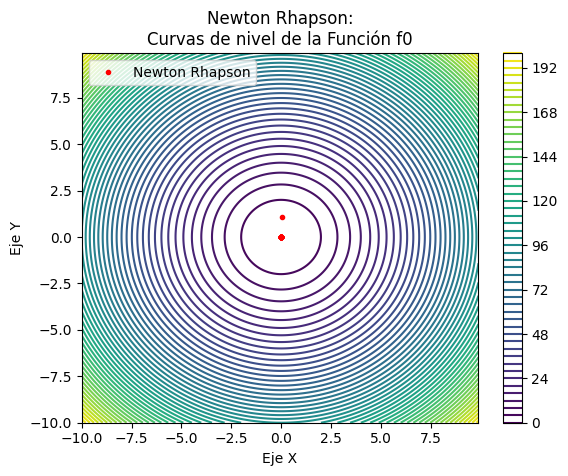

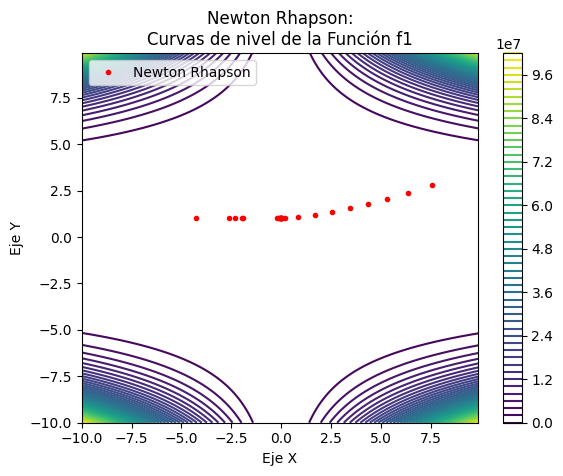

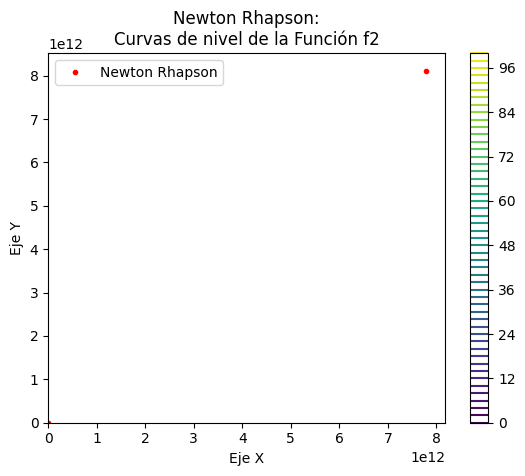

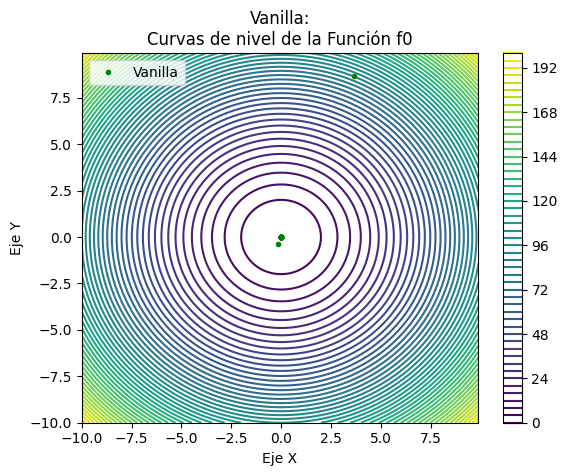

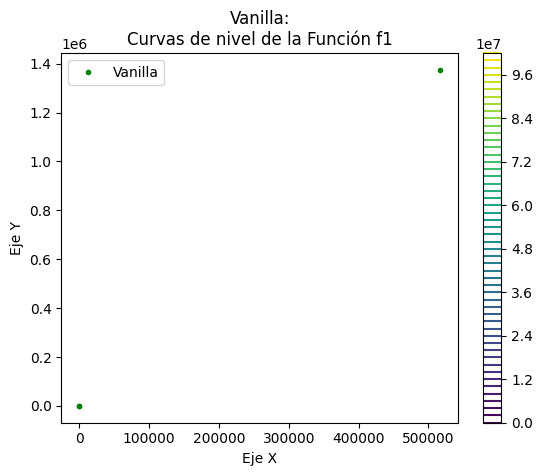

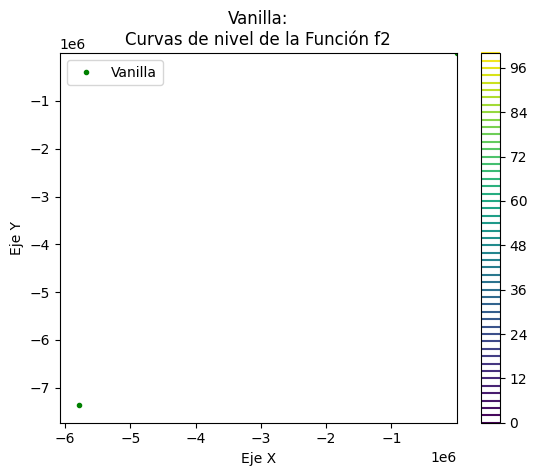

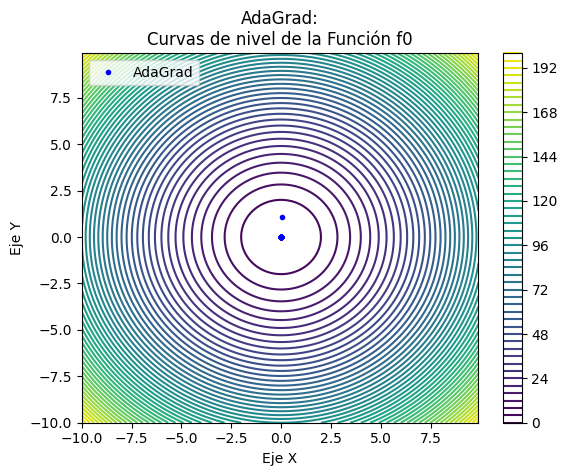

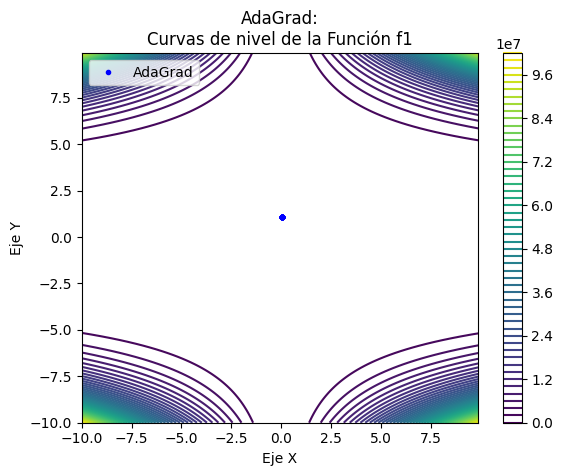

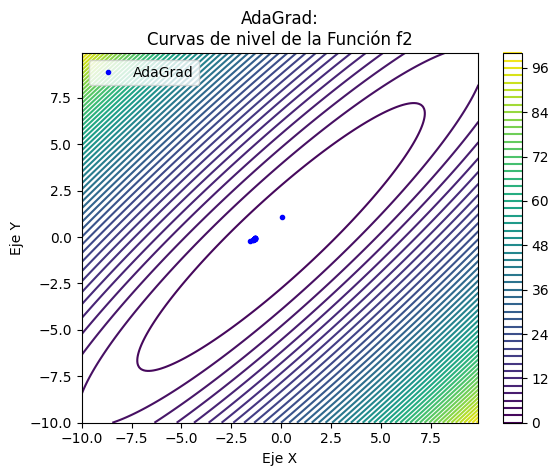

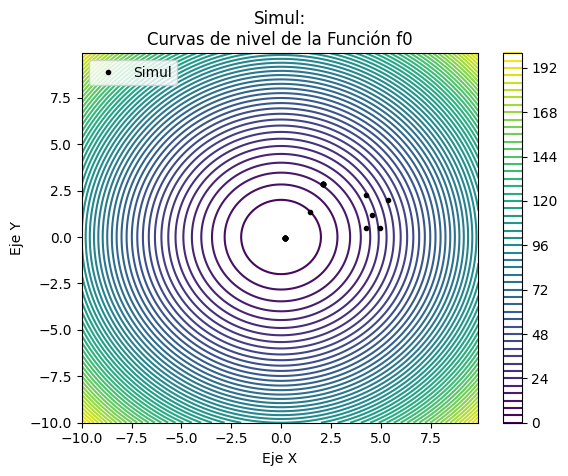

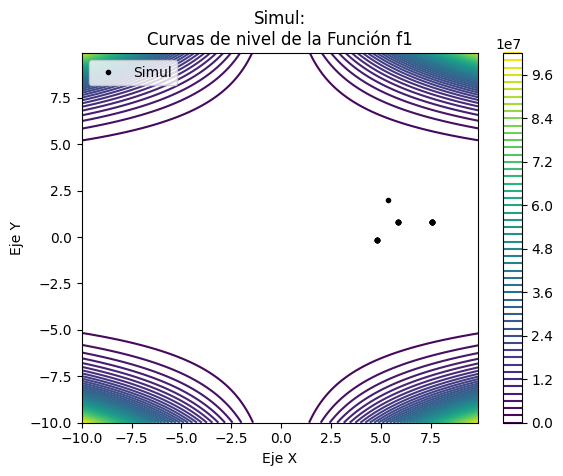

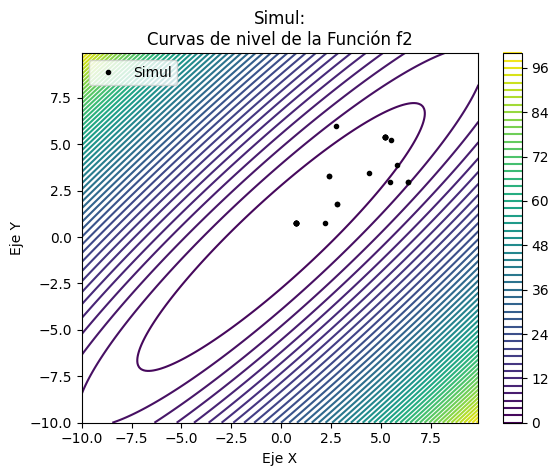

In [39]:
# The above code is creating a loop to iterate over different algorithms. Inside the loop, it
# retrieves the iteration index for each algorithm and then iterates over different functions. For
# each function, it creates a title for the graph, retrieves the points from the results, and calls
# the "graph_stroke" function to plot the graph with the specified algorithm name and color. Finally,
# it prints the result of the "hist" key from the "results" dictionary for the VANILLA algorithm.

Zs = [Z0, Z1, Z2]
colors = ['r', 'g', 'b', 'k']
alg_names = ["Newton Rhapson", "Vanilla", "AdaGrad", "Simul"]
num_of_algorithms = 4

for algorithm in range(num_of_algorithms):

    iter_index = information[algorithm]['Iteración'].to_list()

    for function in range(length_of_functions):
        title = f'{alg_names[algorithm]}:\nCurvas de nivel de la Función f{function}'
        points = results[algorithm]['pos'][iter_index[function]][f'f{function}']
        graph_stroke(points, Zs[function], name=alg_names[algorithm], color=colors[algorithm], title = title)

In [40]:
results[VANILLA]['hist'][0]

,f0,f1,f2
0,8.854670e+01,5.783662e+06,7.728375e+00
1,1.885356e-01,7.161275e+11,2.345933e+12
2,4.014342e-04,inf,NaN
3,8.547448e-07,NaN,NaN
4,1.819944e-09,NaN,NaN
5,3.875074e-12,NaN,NaN
6,8.250898e-15,NaN,NaN
7,1.756805e-17,NaN,NaN
8,3.740634e-20,NaN,NaN
9,7.964660e-23,NaN,NaN


# Test Unitarios

## Vanilla

In [41]:
def test_vanilla_f0():
  """
  The function `test_vanilla_f0` tests the correctness of the `gradient_descent` function by comparing
  the calculated loss, history of f values, and positions with the expected values.
  """
  loss_f0 = torch.tensor(0.001263780985027551)
  hist_f0 = torch.tensor([88.54669952392578, 56.669891357421875, 36.26872634887695, 23.21198272705078, 14.855669975280762, 9.50762939453125, 6.0848822593688965, 3.894325017929077, 2.49236798286438, 1.5951155424118042, 1.0208740234375, 0.6533593535423279, 0.41815000772476196, 0.26761600375175476, 0.17127427458763123, 0.10961552709341049, 0.07015393674373627, 0.04489852115511894, 0.028735052794218063, 0.018390433862805367, 0.01176987774670124, 0.007532721851021051, 0.00482094194740057, 0.0030854027718305588, 0.001974657643586397])
  pos_f0 = torch.tensor([[3.6787831783294678, 8.661019325256348], [2.943026542663574, 6.9288153648376465], [2.3544211387634277, 5.5430521965026855], [1.8835369348526, 4.434441566467285], [1.5068295001983643, 3.547553300857544], [1.2054636478424072, 2.838042736053467], [0.9643709063529968, 2.2704341411590576], [0.7714967131614685, 1.816347360610962], [0.6171973943710327, 1.4530779123306274], [0.4937579035758972, 1.1624623537063599], [0.39500632882118225, 0.9299699068069458], [0.31600505113601685, 0.7439759373664856], [0.2528040409088135, 0.5951807498931885], [0.20224323868751526, 0.47614461183547974], [0.16179458796977997, 0.38091570138931274], [0.1294356733560562, 0.3047325611114502], [0.10354854166507721, 0.2437860518693924], [0.08283883333206177, 0.19502884149551392], [0.06627106666564941, 0.1560230702161789], [0.05301685258746147, 0.12481845915317535], [0.04241348057985306, 0.09985476732254028], [0.033930785953998566, 0.07988381385803223], [0.027144629508256912, 0.06390704959630966], [0.02171570435166359, 0.05112563818693161], [0.01737256348133087, 0.04090050980448723]])

  loss, f_hist, pos = gradient_descent(f0, gradient_f0)
  assert torch.allclose(loss.float(), loss_f0.float(), rtol=1e-6, atol=1e-6)
  assert all(abs(a - b) < 1e-6 for a, b in zip(f_hist, hist_f0))
  pos = [torch.tensor(p) for p in pos]
  pos_f0 = [torch.tensor(p) for p in pos_f0]
  for a, b in zip(pos, pos_f0):
    assert torch.allclose(a, b, rtol=1e-6, atol=1e-6)

def test_vanilla_f0_2():
  """
  The function `test_vanilla_f0_2` tests the correctness of a gradient descent algorithm by comparing
  the loss, history, and positions obtained from the algorithm with expected values.
  """
  loss_f0 = torch.tensor(0.0)
  hist_f0 = torch.tensor([88.54669952392578, 0.18853560090065002, 0.00040143419755622745, 8.547447691853449e-07, 1.8199441953470341e-09, 3.875073872894319e-12, 8.250897964260252e-15, 1.7568048969927877e-17, 3.7406344839392473e-20, 7.964660292183217e-23, 1.6958532379608044e-25, 3.6108569599948736e-28, 7.688326443926055e-31, 1.637018044868088e-33, 3.485585405689566e-36, 7.421589156621776e-39, 1.5802442782190962e-41, 3.363116314379561e-44, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
  pos_f0 = torch.tensor([[3.6787831783294678, 8.661019325256348], [-0.1697521209716797, -0.39964962005615234], [0.007832959294319153, 0.018441230058670044], [-0.0003614407032728195, -0.000850943848490715], [1.6678153770044446e-05, 3.92655492760241e-05], [-7.695889507886022e-07, -1.8118516891263425e-06], [3.551156169123715e-08, 8.360518677363871e-08], [-1.6386287882141914e-09, -3.857842045817961e-09], [7.561207215900367e-11, 1.7801449203602715e-10], [-3.4890076938687287e-12, -8.214220970081954e-12], [1.6099534899671752e-13, 3.790327426922424e-13], [-7.428899075762052e-15, -1.7489915765667163e-14], [3.4279592781970986e-16, 8.070462158803193e-16], [-1.5817810894382025e-17, -3.7239962344712925e-17], [7.298892832657657e-19, 1.7183850045176597e-18], [-3.3679692615862213e-20, -7.92922927484144e-20], [1.5541011187509464e-21, 3.65882664447518e-21], [-7.171167195726747e-23, -1.688312788724809e-22], [3.309031683686957e-24, 7.790474755600624e-24], [-1.526903390927686e-25, -3.5947997020468897e-25], [7.045674197126535e-27, 1.6587674076921673e-26], [-3.251123820521205e-28, -7.654138637060638e-28], [1.5001838708809935e-29, 3.5318907026388373e-29], [-6.922379026907656e-31, -1.6297399745337076e-30], [3.1942319251956446e-32, 7.520192195543761e-32]])

  loss, f_hist, pos = gradient_descent(f0, gradient_f0, alpha=best_alpha_vanilla_f0)
  assert torch.allclose(loss.float(), loss_f0.float(), rtol=1e-6, atol=1e-6)
  assert all(abs(a - b) < 1e-6 for a, b in zip(f_hist, hist_f0))
  pos = [torch.tensor(p) for p in pos]
  pos_f0 = [torch.tensor(p) for p in pos_f0]
  for a, b in zip(pos, pos_f0):
    assert torch.allclose(a, b, rtol=1e-6, atol=1e-6)

test_vanilla_f0()
test_vanilla_f0_2()

<ipython-input-41-d05d64d6ff8c>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_f0 = [torch.tensor(p) for p in pos_f0]
<ipython-input-41-d05d64d6ff8c>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_f0 = [torch.tensor(p) for p in pos_f0]


# AdaGrad

In [42]:
def test_adagrad_f0():
  """
  The function `test_adagrad_f0` tests the `adaptive_gradient_descent` function by comparing its
  output with expected values.
  """
  loss_f0 = torch.tensor(56.513458251953125)
  hist_f0 = torch.tensor([88.54669952392578, 56.669891357421875, 56.654090881347656, 56.641761779785156, 56.631309509277344, 56.6220703125, 56.613704681396484, 56.60601043701172, 56.59884262084961, 56.59210205078125, 56.585731506347656, 56.57966232299805, 56.57386016845703, 56.568302154541016, 56.562950134277344, 56.55778884887695, 56.55279541015625, 56.54795455932617, 56.543251037597656, 56.538673400878906, 56.53422164916992, 56.52988052368164, 56.525638580322266, 56.52149200439453, 56.517433166503906])
  pos_f0 = torch.tensor([[3.6787831783294678, 8.661019325256348], [2.943026542663574, 6.9288153648376465], [2.9422266483306885, 6.928015232086182], [2.9416022300720215, 6.9273905754089355], [2.941072702407837, 6.926860809326172], [2.9406046867370605, 6.926392555236816], [2.940181016921997, 6.925968647003174], [2.939790964126587, 6.925578594207764], [2.939427614212036, 6.925215244293213], [2.9390861988067627, 6.9248738288879395], [2.93876314163208, 6.924550533294678], [2.938455581665039, 6.924242973327637], [2.938161849975586, 6.923948764801025], [2.937880039215088, 6.923666954040527], [2.9376087188720703, 6.92339563369751], [2.937346935272217, 6.923133850097656], [2.937093734741211, 6.92288064956665], [2.9368481636047363, 6.922635078430176], [2.9366097450256348, 6.922396659851074], [2.936378002166748, 6.922164440155029], [2.936152219772339, 6.921938419342041], [2.935931921005249, 6.921718120574951], [2.9357168674468994, 6.921503067016602], [2.935506582260132, 6.921292781829834], [2.935300827026367, 6.92108678817749]])
  loss, f_hist, pos = adaptive_gradient_descent(f0, gradient_f0)

  assert torch.allclose(loss.float(), loss_f0.float(), rtol=1e-6, atol=1e-6)
  assert all(abs(a - b) < 1e-6 for a, b in zip(f_hist, hist_f0))
  pos = [torch.tensor(p) for p in pos]
  pos_f0 = [torch.tensor(p) for p in pos_f0]
  for a, b in zip(pos, pos_f0):
    assert torch.allclose(a, b, rtol=1e-6, atol=1e-6)


def test_adagrad_f0_2():
  """
  The function `test_adagrad_f0_2` tests the accuracy of the `adaptive_gradient_descent` function by
  comparing the calculated loss, history, and positions with expected values.
  """
  loss_f0 = torch.tensor(0.001038486254401505)
  hist_f0 = torch.tensor([88.54669952392578, 0.0010735973482951522, 0.0010721071157604456, 0.0010706190951168537, 0.0010691335191950202, 0.0010676505044102669, 0.0010661697015166283, 0.0010646914597600698, 0.001063215546309948, 0.0010617419611662626, 0.0010602708207443357, 0.0010588020086288452, 0.0010573356412351131, 0.0010558716021478176, 0.0010544098913669586, 0.001052950625307858, 0.001051493687555194, 0.0010500390781089664, 0.0010485867969691753, 0.0010471368441358209, 0.001045689219608903, 0.0010442440398037434, 0.0010428010718896985, 0.0010413604322820902, 0.0010399222373962402])
  pos_f0 = torch.tensor([[3.6787831783294678, 8.661019325256348], [0.01280975341796875, 0.030158042907714844], [0.012792403809726238, 0.030140694230794907], [0.012775077484548092, 0.030123354867100716], [0.012757775373756886, 0.03010602481663227], [0.012740496546030045, 0.03008870594203472], [0.012723241001367569, 0.030071396380662918], [0.012706008739769459, 0.03005409799516201], [0.012688799761235714, 0.03003680892288685], [0.01267161499708891, 0.030019529163837433], [0.01265445351600647, 0.030002260580658913], [0.012637315317988396, 0.02998500131070614], [0.012620200403034687, 0.02996775321662426], [0.012603108771145344, 0.029950514435768127], [0.012586040422320366, 0.02993328496813774], [0.012568995356559753, 0.02991606667637825], [0.012551973573863506, 0.029898857697844505], [0.01253497414290905, 0.029881658032536507], [0.012517997995018959, 0.029864469543099403], [0.012501045130193233, 0.029847290366888046], [0.012484115548431873, 0.029830120503902435], [0.012467209249734879, 0.02981296181678772], [0.012450325302779675, 0.02979581244289875], [0.012433464638888836, 0.029778674244880676], [0.012416627258062363, 0.02976154536008835]])
  loss, f_hist, pos = adaptive_gradient_descent(f0, gradient_f0, best_alpha_rho_f0)
  assert torch.allclose(loss.float(), loss_f0.float(), rtol=1e-6, atol=1e-6)
  assert all(abs(a - b) < 1e-6 for a, b in zip(f_hist, hist_f0))
  pos = [torch.tensor(p) for p in pos]
  pos_f0 = [torch.tensor(p) for p in pos_f0]
  for a, b in zip(pos, pos_f0):
    assert torch.allclose(a, b, rtol=1e-6, atol=1e-6)

test_adagrad_f0_2()
test_adagrad_f0()

<ipython-input-42-926dd07eefba>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_f0 = [torch.tensor(p) for p in pos_f0]
<ipython-input-42-926dd07eefba>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_f0 = [torch.tensor(p) for p in pos_f0]


# Newton Raphson

In [43]:
def test_newton_f0_2():
  """
  The function `test_newton_f0_2` tests the accuracy of the `newton_rhapson` function by comparing the
  calculated loss, history, and positions with expected values.
  """
  loss_f0 = torch.tensor(0.0)
  hist_f0 = torch.tensor([88.54669952392578, 0.014777742326259613, 2.46626927946636e-06, 4.115988383457392e-10, 6.8692135855343e-14, 1.1464131028666376e-17, 1.913261890589834e-21, 3.1930535506165905e-25, 5.32893982256011e-29, 8.893586016177972e-33, 1.484260804082051e-36, 2.477117334340909e-40, 4.203895392974451e-44, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
  pos_f0 = torch.tensor([[3.6787831783294678, 8.661019325256348], [0.04752492904663086, 0.11188888549804688], [0.0006139576435089111, 0.0014454498887062073], [7.931492291390896e-06, 1.8673250451683998e-05], [1.0246458259643987e-07, 2.4123255570884794e-07], [1.3237055895842786e-09, 3.116397806479654e-09], [1.710054320369636e-11, 4.02595734527722e-11], [2.209152999421704e-13, 5.200978536734624e-13], [2.8539318261064373e-15, 6.718963493218544e-15], [3.6869014853374744e-17, 8.680012478635805e-17], [4.762972141529338e-19, 1.1213392732666852e-18], [6.15313808284055e-21, 1.4486207272488035e-20], [7.949011816178529e-23, 1.8714153565445305e-22], [1.0269075719805043e-24, 2.4176125498999722e-24], [1.3266273843101756e-26, 3.1232383744283994e-26], [1.7138311314717583e-28, 4.034807826051704e-28], [2.214037027005414e-30, 5.2124330979868345e-30], [2.860231662330403e-32, 6.733758262979231e-32], [3.695019555016008e-34, 8.699128393825256e-34], [4.773471337048146e-36, 1.12380933358457e-35], [6.166681820527736e-38, 1.451811574535781e-37], [7.966493873563731e-40, 1.8755427062031936e-39], [1.0291135922001457e-41, 2.422985174664041e-41], [1.3312335411085762e-43, 3.124895575444342e-43], [1.401298464324817e-45, 4.203895392974451e-45]])
  loss, f_hist, pos = newton_rhapson(f0, gradient_f0, inverse_hessian_matrix_f0, best_alpha_newton_f0)

  assert torch.allclose(loss.float(), loss_f0.float(), rtol=1e-6, atol=1e-6)
  assert all(abs(a - b) < 1e-6 for a, b in zip(f_hist, hist_f0))
  pos = [torch.tensor(p) for p in pos]
  pos_f0 = [torch.tensor(p) for p in pos_f0]
  for a, b in zip(pos, pos_f0):
    assert torch.allclose(a, b, rtol=1e-6, atol=1e-6)

def test_newton_f0():
  """
  The function `test_newton_f0` calculates the loss, history, and position using the Newton-Raphson
  method.
  """
  loss_f0 = torch.tensor(0.0)
  hist_f0 = torch.tensor([88.54669952392578, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0, 0.0])
  pos_f0 = torch.tensor([[3.6787831783294678, 8.661019325256348], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0], [0.0, 0.0]])
  loss, f_hist, pos = newton_rhapson(f0, gradient_f0, inverse_hessian_matrix_f0)

  assert torch.allclose(loss.float(), loss_f0.float(), rtol=1e-6, atol=1e-6)
  assert all(abs(a - b) < 1e-6 for a, b in zip(f_hist, hist_f0))
  pos = [torch.tensor(p) for p in pos]
  pos_f0 = [torch.tensor(p) for p in pos_f0]
  for a, b in zip(pos, pos_f0):
    assert torch.allclose(a, b, rtol=1e-6, atol=1e-6)


test_newton_f0()
test_newton_f0_2()

<ipython-input-43-e0a58db79873>:31: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_f0 = [torch.tensor(p) for p in pos_f0]
<ipython-input-43-e0a58db79873>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_f0 = [torch.tensor(p) for p in pos_f0]


# Smiulated Annealing

In [44]:
def test_simulated_f0():
  """
  The function `test_simulated_f0` tests the `simulated_annealing` function by comparing its output
  with expected values.
  """
  loss_f0 = torch.tensor(0.00035728284274227917)
  hist_f0 = torch.tensor([88.54669952392578, 88.54669952392578, 88.54669952392578, 48.746639251708984, 48.746639251708984, 48.746639251708984, 48.746639251708984, 21.853025436401367, 21.336551666259766, 6.9577555656433105, 6.9577555656433105, 4.8980278968811035, 4.8980278968811035, 4.8980278968811035, 4.8980278968811035, 0.12436851114034653, 0.12436851114034653, 0.12436851114034653, 0.12436851114034653, 0.021984588354825974, 0.021984588354825974, 0.021984588354825974, 0.021984588354825974, 0.02212332747876644, 0.00035728284274227917])
  pos_f0 = torch.tensor([[3.6787831783294678, 8.661019325256348], [3.6787831783294678, 8.661019325256348], [2.6088268756866455, 6.476161003112793], [2.6088268756866455, 6.476161003112793], [2.6088268756866455, 6.476161003112793], [2.6088268756866455, 6.476161003112793], [0.6767949461936951, 4.625470161437988], [2.320213794708252, 3.994140625], [1.878284215927124, 1.851973056793213], [1.878284215927124, 1.851973056793213], [0.22763001918792725, 2.201411485671997], [0.22763001918792725, 2.201411485671997], [0.22763001918792725, 2.201411485671997], [0.22763001918792725, 2.201411485671997], [0.06204962730407715, 0.3471575379371643], [0.06204962730407715, 0.3471575379371643], [0.06204962730407715, 0.3471575379371643], [0.06204962730407715, 0.3471575379371643], [0.14806175231933594, -0.00789332389831543], [0.14806175231933594, -0.00789332389831543], [0.14806175231933594, -0.00789332389831543], [0.14806175231933594, -0.00789332389831543], [-0.11757159233093262, -0.09110569953918457], [0.017147302627563477, -0.007953166961669922], [0.017147302627563477, -0.007953166961669922]])
  loss, f_hist, pos = simulated_annealing(f0, best_alpha_S_f0, best_T_t_f0, best_h_f0)

  assert torch.allclose(loss.float(), loss_f0.float(), rtol=1e-6, atol=1e-6)
  assert all(abs(a - b) < 1e-6 for a, b in zip(f_hist, hist_f0))
  pos = [torch.tensor(p) for p in pos]
  pos_f0 = [torch.tensor(p) for p in pos_f0]
  for a, b in zip(pos, pos_f0):
    assert torch.allclose(a, b, rtol=1e-6, atol=1e-6)


def test_simulated_f1():
  """
  The function `test_simulated_f1` tests the simulated_annealing function by comparing its output with
  expected values.
  """
  loss_f0 = torch.tensor(0.12867972254753113)
  hist_f0 = torch.tensor([5783661.5, 1983186.625, 1983186.625, 5808.9609375, 5808.9609375, 5808.9609375, 5808.9609375, 5808.9609375, 5808.9609375, 2929.97998046875, 2929.97998046875, 2929.97998046875, 2929.97998046875, 2929.97998046875, 2929.97998046875, 3.039726495742798, 0.2941906452178955, 0.2941906452178955, 0.2941906452178955, 0.2941906452178955, 0.2941906452178955, 0.2941906452178955, 0.2941906452178955, 0.2941906452178955, 0.12867972254753113])
  pos_f0 = torch.tensor([[1.308579444885254, 10.227928161621094], [1.308579444885254, 10.227928161621094], [-0.21868252754211426, 7.109248161315918], [-0.21868252754211426, 7.109248161315918], [-0.21868252754211426, 7.109248161315918], [-0.21868252754211426, 7.109248161315918], [-0.21868252754211426, 7.109248161315918], [-0.21868252754211426, 7.109248161315918], [-0.8494954109191895, 4.0515055656433105], [-0.8494954109191895, 4.0515055656433105], [-0.8494954109191895, 4.0515055656433105], [-0.8494954109191895, 4.0515055656433105], [-0.8494954109191895, 4.0515055656433105], [-0.8494954109191895, 4.0515055656433105], [-1.085846185684204, 1.404732584953308], [2.189793109893799, 0.19391155242919922], [2.189793109893799, 0.19391155242919922], [2.189793109893799, 0.19391155242919922], [2.189793109893799, 0.19391155242919922], [2.189793109893799, 0.19391155242919922], [2.189793109893799, 0.19391155242919922], [2.189793109893799, 0.19391155242919922], [2.189793109893799, 0.19391155242919922], [2.382091999053955, 0.3126041889190674], [2.382091999053955, 0.3126041889190674]])
  loss, f_hist, pos = simulated_annealing(f1, best_alpha_S_f1, best_T_t_f1, best_h_f1)

  assert torch.allclose(loss.float(), loss_f0.float(), rtol=1e-6, atol=1e-6)
  assert all(abs(a - b) < 1e-6 for a, b in zip(f_hist, hist_f0))
  pos = [torch.tensor(p) for p in pos]
  pos_f0 = [torch.tensor(p) for p in pos_f0]
  for a, b in zip(pos, pos_f0):
    assert torch.allclose(a, b, rtol=1e-6, atol=1e-6)

test_simulated_f0()
test_simulated_f1()

<ipython-input-44-47eff4fc9e37>:14: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_f0 = [torch.tensor(p) for p in pos_f0]
<ipython-input-44-47eff4fc9e37>:32: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  pos_f0 = [torch.tensor(p) for p in pos_f0]
